# Úkol č. 2 - Využití neuronových sítí

  * **Deadline je do 18. 5. 2023, 23:59:59**, pokud odevzdáte úkol do 24. 5. 2023, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu musíte sestrojit vhodný model neuronové sítě pro vícetřídou klasifikaci.
  * Část bodů získáte za správné vypracování a část bodů získáte za výslednou přesnost Vašeho modelu na evaluačních datech.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 32x32 pixelů ve stupních šedi, které byly nějakým způsobem vyrobeny z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování (max 18 bodů)

**Body zadání**, za jejichž (poctivé) vypracování získáte **18 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Sestrojte a natrénujte několik variant modelu dopředné neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.

  * Sestrojte model konvoluční neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **predikce labelu**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Vyhodnocovací část (max 7 bodů)
Za přesnost (accuraccy) na odevzdaných predikcích pro vyhodnocovací množnu získáte dalších max **7 bodů**.

Označíme-li $A$ přesnost, které jste dosáhli, zaokrouhlenou na 2 desetinná místa, akumulují se výsledné body podle následujících pravidel:
* pokud $A \geq 0.80$ obdržíte +1 bod
* pokud $A \geq 0.83$ obdržíte +1 bod
* pokud $A \geq 0.86$ obdržíte +1 bod
* pokud $A \geq 0.87$ obdržíte +1 bod
* pokud $A \geq 0.88$ obdržíte +1 bod
* pokud $A \geq 0.89$ obdržíte +1 bod
* pokud $A \geq 0.90$ obdržíte +1 bod

**Příklad:** Pokud bude Vaše přesnost 0.856, vyjde A = 0.86 a vy získáte 3 body.


## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [3]:
# datová analytika
import pandas as pd
import numpy as np

# grafy
import matplotlib.pyplot as plt

# vyhodnocování a předzpracování
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix

import random

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split


### Rozdělení do podmnožin

Načtení dat

In [8]:
df = pd.read_csv("train.csv")

In [9]:
TEST_SIZE = 0.15
TRAIN_SIZE = 0.8
RANDOM_SEED = 666
random_generator = torch.Generator().manual_seed(RANDOM_SEED)

In [10]:
# Rozdělení datasetu na vysvětlovaný příznak a zbylá data
X = df.drop("label", axis=1)
y = df["label"]

Rozdělení datasetu na trénovací a testovací množinu.


In [11]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, train_size=1-TEST_SIZE, random_state=RANDOM_SEED)

print(f"Počet dat v trénovací množině: {X_Train.shape[0]} ({int((1-TEST_SIZE) * 100)} %)")
print(f"Počet dat v testovací množině: {X_Test.shape[0]} ({int((TEST_SIZE) * 100)} %)")

Počet dat v trénovací množině: 47600 (85 %)
Počet dat v testovací množině: 8400 (15 %)


Převod množin na tenzory

In [12]:
X_Train_tensor = torch.tensor(X_Train.values, dtype = torch.float32)
y_Train_tensor = torch.tensor(y_Train.values, dtype = torch.long)

X_Test_tensor = torch.tensor(X_Test.values, dtype = torch.float32)
y_Test_tensor = torch.tensor(y_Test.values, dtype = torch.long)

Převod na dataset tenzorů a rozdělení datasetu na trénovací a validační.

In [13]:
dataset = TensorDataset(X_Train_tensor, y_Train_tensor)
test_dataset = TensorDataset(X_Test_tensor, y_Test_tensor)

train_data, val_data = random_split(dataset, [TRAIN_SIZE, 1 - TRAIN_SIZE], random_generator)

## Průzkum dat

Dataset obsahuje 56000 obrázků 32 x 32 pixelů se barevnou hloubkou 1.

In [29]:
print("Rozměry datasetu:", df.shape)

DATA_DIM = len(X.values[0]) # počet 

Rozměry datasetu: (56000, 1025)


Základní pohled na data.

In [9]:
df.describe()

pix1          pix2          pix3          pix4          pix5  \
count  56000.000000  56000.000000  56000.000000  56000.000000  56000.000000   
mean       0.873482      0.873482      0.873482      0.873482      0.873500   
std        1.493611      1.493611      1.493611      1.493611      1.493642   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max       11.000000     11.000000     11.000000     11.000000     11.000000   

               pix6          pix7          pix8          pix9         pix10  \
count  56000.000000  56000.000000  56000.000000  56000.000000  56000.000000   
mean       0.873500      0.873536      0.873679      0.877179      0.883036   
std        1.493642      1.493681      1.493741      1.557755      1.763484   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max       11.000000     11.000000     11.000000     80.000000    168.000000   

       ...       pix1016       pix1017       pix1018       pix1019  \
count  ...  56000.000000  56000.000000  56000.000000  56000.000000   
mean   ...      0.899732      0.897536      0.888554      0.878393   
std    ...      2.041735      2.039311      1.995824      1.587205   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      1.000000      1.000000      1.000000      1.000000   
max    ...    141.000000    168.000000    210.000000    107.000000   

            pix1020       pix1021      pix1022       pix1023       pix1024  \
count  56000.000000  56000.000000  56000.00000  56000.000000  56000.000000   
mean       0.874071      0.873589      0.87350      0.873482      0.873482   
std        1.494407      1.493691      1.49369      1.493611      1.493611   
min        0.000000      0.000000      0.00000      0.000000      0.000000   
25%        0.000000      0.000000      0.00000      0.000000      0.000000   
50%        0.000000      0.000000      0.00000      0.000000      0.000000   
75%        1.000000      1.000000      1.00000      1.000000      1.000000   
max       11.000000     11.000000     11.00000     11.000000     11.000000   

              label  
count  56000.000000  
mean       4.494393  
std        2.872563  
min        0.000000  
25%        2.000000  
50%        4.000000  
75%        7.000000  
max        9.000000  

[8 rows x 1025 columns]

In [28]:
unique_vals = set(i for i in df["label"])
print("Unikátní hodnoty ve sloupci label:\n", unique_vals)

CLASS_COUNT = len(unique_vals)

Unikátní hodnoty ve sloupci label:
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [11]:
res = set()
for col in df.columns:
    for j in df[col]:
        res.add(j)

print("Sloupce s pixely obsahují všechny hodnoty mezi 0 a 255:", res == set(i for i in range(0, 256)))

Sloupce s pixely obsahují všechny hodnoty mezi 0 a 255: True


Vizualizace několika datových bodů.

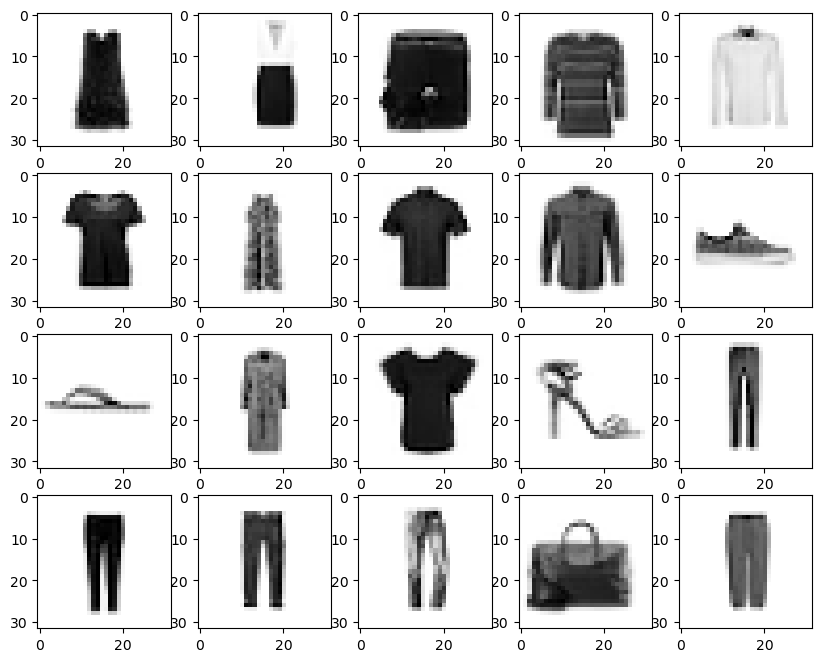

In [12]:
# přeměna datových bodů na 2D pole velikosti 32x32
images = df.drop("label", axis=1).values.reshape((len(df["label"]), 32, 32))

# vytvoření figure s 5 sloupci
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
for row in axes:
    for col in row:
        rand_pos = random.randrange(0, len(images)) # vygenerování náhodné hodnoty
        col.imshow(images[rand_pos], cmap='Greys') # zobrazení datového bodu

#### Než budeme experimentovat s různými neuronovými sítěmi, připravíme si funkce pro trénování modelů.

Během trénování vyhodnocujeme kumulativní chybu a přesnost modelu.

- Kumulativní chyba pomáhá odhalit přeučení a vhodný počet epoch.

- Přesnost nám prozradí, kolik procent dat z validační, případně testovací množiny, bylo v daný moment měření predikováno dobře.

*Funkce trénující model přes jednu epochu a vyhodnocující model na trénovací množině.*

In [14]:
def train_one_epoch(model, optimizer, loss_fn, training_loader):
    running_cum_loss = 0. # kumulativní chyba
    correct = 0 # počet správně klasifikovaných

    for inputs, labels in training_loader:
        # Vynulování gradientu v každé dávce
        optimizer.zero_grad()

        # Dopředný průchod sítí
        outputs = model(inputs)

        # Výpočet hodnoty účelové funkce
        loss = loss_fn(outputs, labels)
        
        # Zpětné šíření chyby přes gradient
        loss.backward()

        # Aktualizace vah
        optimizer.step()

        # Sběr výsledků
        running_cum_loss += loss.item() * inputs.shape[0]
        correct += (outputs.argmax(1) == labels).sum()

    # průměrná hodnota účelové funkce na celém trénovacím datasetu
    return running_cum_loss / len(train_data), correct * 100 / len(train_data)

*Funkce počítající kumulativní chybu a přesnost na validační množině.*

In [15]:
def validate_model(model, loss_fn, validation_loader):
    running_cum_vloss = 0.0
    vcorrect = 0

    with torch.no_grad(): # výpočet bez gradientu
        for vinputs, vlabels in validation_loader:
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)

            # Spočítání kumulativní chyby a správně klasifikovaných
            running_cum_vloss += vloss.item() * vinputs.shape[0]
            vcorrect += (voutputs.argmax(1) == vlabels).sum()

    # Průměrná kumulativní ztráta a přesnost
    return running_cum_vloss / len(val_data), vcorrect * 100 / len(val_data)

*Třída zajišťující regularizační metodu Early Stopping.*

In [16]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.early_stop = False
        self.patience = patience
        self.best_loss = None
        self.not_improved = 0

    def __call__(self, vloss, model = None):
        if self.best_loss is None or self.best_loss > vloss:
            self.best_loss = vloss
            self.not_improved = 0
        else:
            self.not_improved += 1
            if self.not_improved >= self.patience:
                return True
            
        return False

*Funkce zajišťující trénování modelu a sběr hodnocení modelu v epochách.*

In [17]:
def train(model, optimizer, loss_fn, training_loader, validation_loader, patience, epochs):
    # inicializace polí pro sběr výsledků trénování
    losses = []
    accs = []
    vlosses = []
    vaccs = []

    # zavedení early stoppingu
    early_stopping = EarlyStopping(patience)

    for _ in range(epochs):
        model.train() # indikace trénování (např. pro dropout vrstvu)
        loss, acc = train_one_epoch(model, optimizer, loss_fn, training_loader)
        model.eval() # indikace validace
        vloss, vacc = validate_model(model, loss_fn, validation_loader)

        if early_stopping(vloss, model): # předčasné ukončení
            break

        # uložení výsledků pro danou epochu
        losses.append(loss)
        accs.append(acc)
        vlosses.append(vloss)
        vaccs.append(vacc)

    return losses, accs, vlosses, vaccs

*Funkce na vizualizaci výsledků trénování modelu v jednotlivých epochách při daných hyperparametrech.*

In [18]:
POINT_SIZE = 8
def plot_result(losses, accs, vlosses, vaccs):
    print(f"\nNejlepší výsledek na validační množině (epocha={np.argmax(vaccs)+1}):\n  Ztrátová funkce={max(vlosses):.5f}, Přesnost={max(vaccs):.2f}%")
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
    fig.suptitle("Výsledky trénování - kumulativní chyba a přesnost predikce")
    ax[0].set_xlabel("Epocha")
    ax[0].set_ylabel("Kumulativní chyba")
    ax[0].scatter(range(1, len(losses)+1), losses, c='blue', label="Trénovací", s = POINT_SIZE)
    ax[0].scatter(range(1, len(vlosses)+1), vlosses, c='red', label="Validační", s = POINT_SIZE)
    ax[0].legend()

    ax[1].set_xlabel("Epocha")
    ax[1].set_ylabel("Přesnost")
    ax[1].scatter(range(1, len(accs)+1), accs, c='blue', label="Trénovací", s = POINT_SIZE)
    ax[1].scatter(range(1, len(vaccs)+1), vaccs, c='red', label="Validační", s = POINT_SIZE)
    ax[1].plot([1, len(vaccs)+1], [max(vaccs), max(vaccs)],'g--', label="Nejvyšší přesnost na validační množině")
    ax[1].legend()
    plt.show()

*Funkce inicializující model dopředné neuronové sítě, optimalizační metodu a dávkovače dat pro trénování.*

In [18]:
def init_model_mlp(network, neuron_count, hidden, opt_method, learning_rate, L2_reg, batch_size):
    # inicializace modelu
    model = network(neuron_count, hidden)

    # inicializace optimalizační metody
    optimizer = opt_method(model.parameters(), lr=learning_rate, weight_decay=L2_reg) # weight_decay ovlivňuje regularizaci L2 normy vah

    # inicializace dávkovačů trénovacích a validačních dat
    training_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # parametr shuffle zamíchá dávku
    validation_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return model, optimizer, training_loader, validation_loader

# Dopředná neuronová síť

Nejprve vytvoříme třídu modelu vícevrstvého perceptronu.

Parametrem dostává hyperparametry:
- počet neuronů ve vrstvě
- aktivační funkci skryté vrstvy

*Poznámka: z výpočetních důvodů vynechávám dropout a dávkovou normalizaci, kterou budu používat u konvoluční sítě.*

První model dopředné sítě se skládá ze tří vrstev.
* Do první vrstvy vstupuje celý rozměr obrázku a velikost výstupu je dynamická podle parametru neuron_count
* Po ní následuje aplikace aktivační funkce předávaná parametrem
* Poslední vrstva už jenom převádí rozměr výstupu na počet tříd

In [19]:
class MLPNeuralNetwork(nn.Module):
    def __init__(self, neuron_count, hidden):
        super(MLPNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(DATA_DIM, neuron_count) # první vrstva
        self.fc2 = nn.Linear(neuron_count, CLASS_COUNT) # transformace na výsledek
        self.hidden = hidden # aktivační funkce skryté vrstvy

    def forward(self, x):
        x = self.fc1(x)
        x = self.hidden(x)
        x = self.fc2(x)
        return x

Druhý model dopředné sítě se skládá ze čtyř vrstev.
* Do první vrstvy vstupuje celý rozměr obrázku a velikost výstupu je dynamická podle parametru neuron_count
* Po ní následuje aplikace aktivační funkce předávaná parametrem
* Druhá lineární vrstva rozšiřuje rozměr výstupu po aplikaci aktivační funkce
* Poslední vrstva opět převádí rozměr výstupu na počet tříd

In [20]:
class MLPNeuralNetwork2(nn.Module):
    def __init__(self, neuron_count, hidden):
        super(MLPNeuralNetwork2, self).__init__()
        self.fc1 = nn.Linear(DATA_DIM, neuron_count // 2) # první vrstva
        self.fc2 = nn.Linear(neuron_count // 2, neuron_count) # druhá vrstva
        self.fc3 = nn.Linear(neuron_count, CLASS_COUNT) # transformace na výsledek
        self.hidden = hidden # aktivační funkce skryté vrstvy

    def forward(self, x):
        x = self.fc1(x)
        x = self.hidden(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [21]:
MODELS = [MLPNeuralNetwork, MLPNeuralNetwork2]

Vhodnou účelovou funkcí pro predikci příznaku s 10ti třídami je `kategorická relativní entropie`. Ta v sobě obsahuje softmax funkci a *nepotřebujeme výstupní aktivační funkci*.

In [22]:
LOSS_FN = nn.CrossEntropyLoss() # účelová funkce

*Hyperparametry modelu, které budeme ladit:*

**Počet neuronů a velikost dávky**
- malá hodnota nevystihne model dobře, ale vysoká bude náchylná na přeučení.
- Ze zkušeností z předešlých experimentů jsem vybral tyto hodnoty k lazení.

In [23]:
NEURON_COUNTS = [128, 256] # počet neuronů ve vrstvě
BATCH_SIZES = [128] # velikost dávky při trénování

**Aktivační funkce**
- Jsou náchylné na inicializaci parametrů a chovají se různě pro záporné hodnoty při výpočtu gradientu.
- Experimentoval jsem s `ReLU`, `LeakyReLU` a `SELU`, ale z důvodů výpočetní náročnosti prezentuji jen `ReLU` a `LeakyReLU`.

In [24]:
HIDDENS = [nn.ReLU(), nn.LeakyReLU()] # aktivační funkce skrytých vrstev

**Optimalizační metody**
- K trénování budeme používat `ADAM` a `SGD`. ADAM používá adaptivní učící parametry a je nejpoužívanější, takže očekáváme lepší výsledky.

In [25]:
OPTIMIZERS = [optim.Adam, optim.SGD] # optimalizační metody gradientního sestupu

**Regularizační techniky**
- Budeme experimentovat s `L2 regularizací` jakožto zástupcem penalizace norem vektorů.
- Dále zapneme `Early Stopping` k detekci přeučení.
- Dále jsem v modelu používal `Dropout` vrstvu, vypínající náhodně některé výstupy vrstvy, kterou se snažíme model generalizovat. Tento model je avšak tak jednoduchý, že dropout nemá významné účinky, a proto jí vynechávám.

In [26]:
L2_REGS = [0, 0.001] # L2 regularizace (0 znamená žádná)
EARLY_STOPPING_PATIENCE = [10] # velikost tolerované sekvence zhoršování modelu

Posledním parametrem, který se přímo neladí při trénování je **maximální počet epoch**, přes které model trénujeme. Ten bude redukován Early Stoppingem. 

In [26]:
EPOCHS = 100 # maximální počet epoch
LEARNING_RATE = 0.001 # statický parametr optimalizační metody SGD

V samotném trénování iterujeme přes možné kombinace hyperparametrů a vizualizujeme výsledek trénování při daných parametrech.

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=18):
  Ztrátová funkce=0.7, Přesnost=80.5%


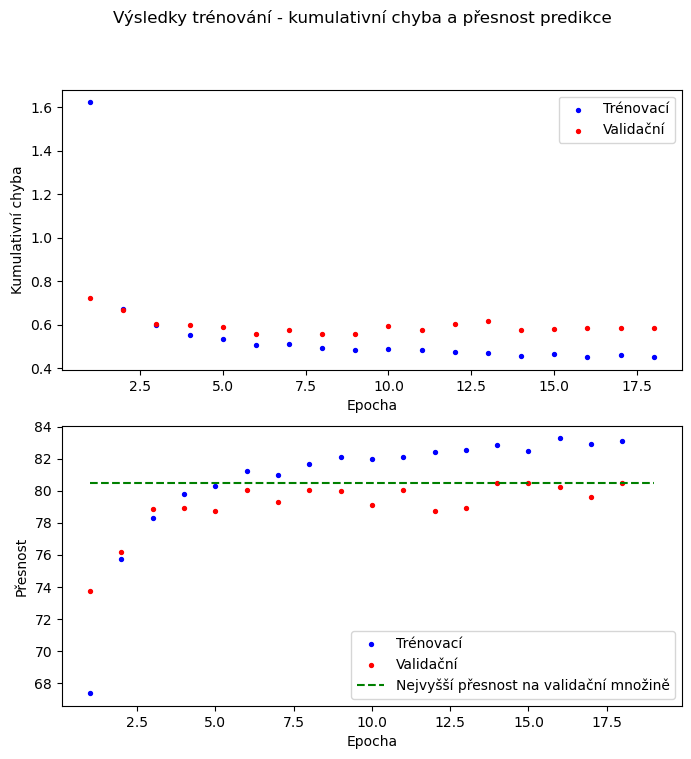

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=11):
  Ztrátová funkce=0.8, Přesnost=78.2%


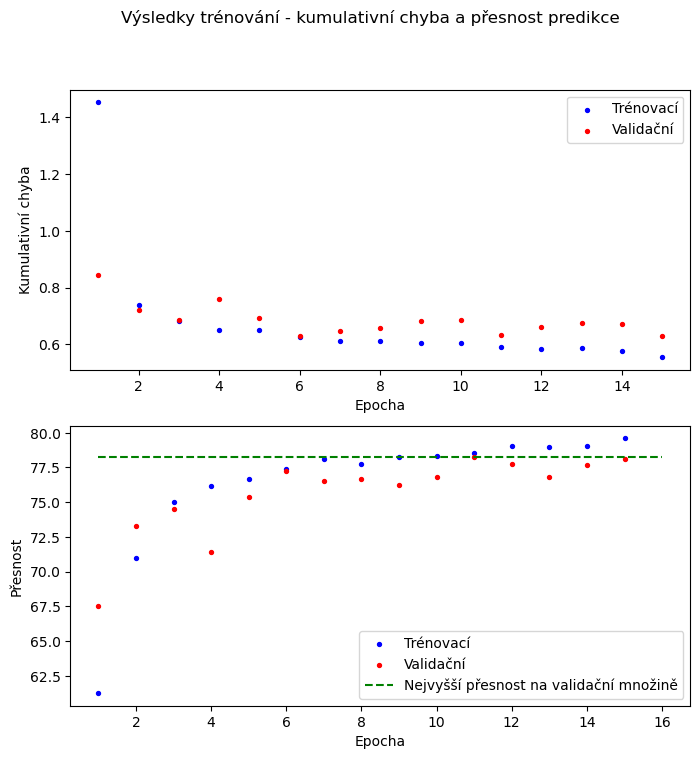

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=45):
  Ztrátová funkce=0.9, Přesnost=81.4%


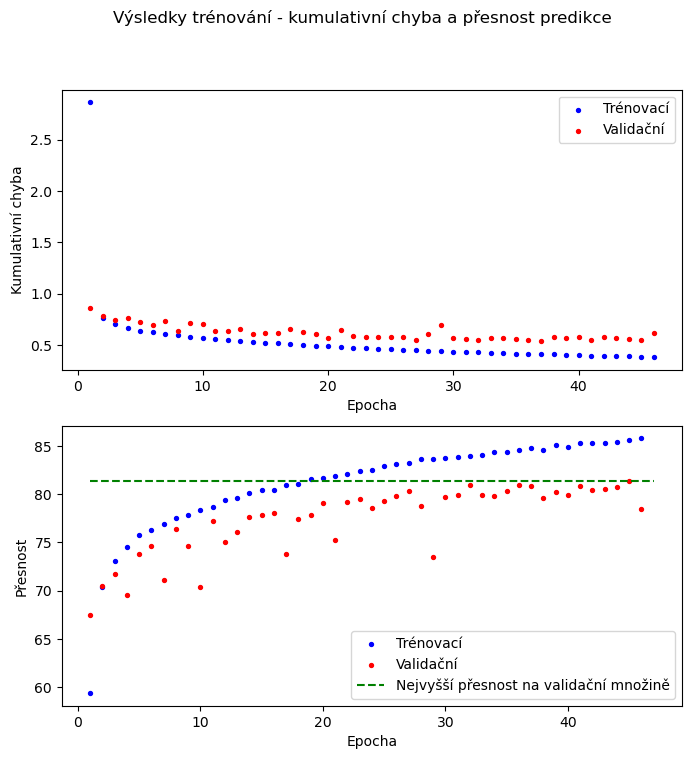

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=48):
  Ztrátová funkce=0.9, Přesnost=81.1%


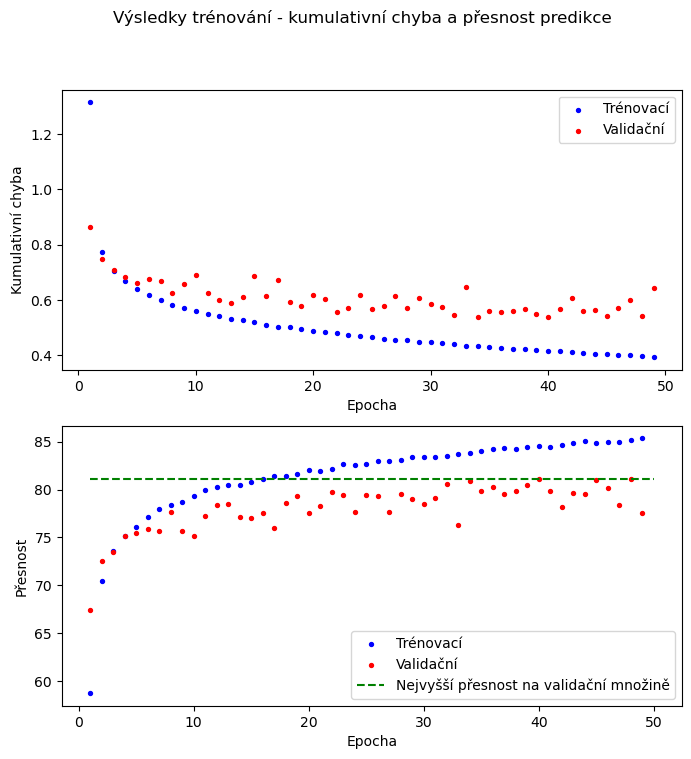

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=14):
  Ztrátová funkce=0.8, Přesnost=80.9%


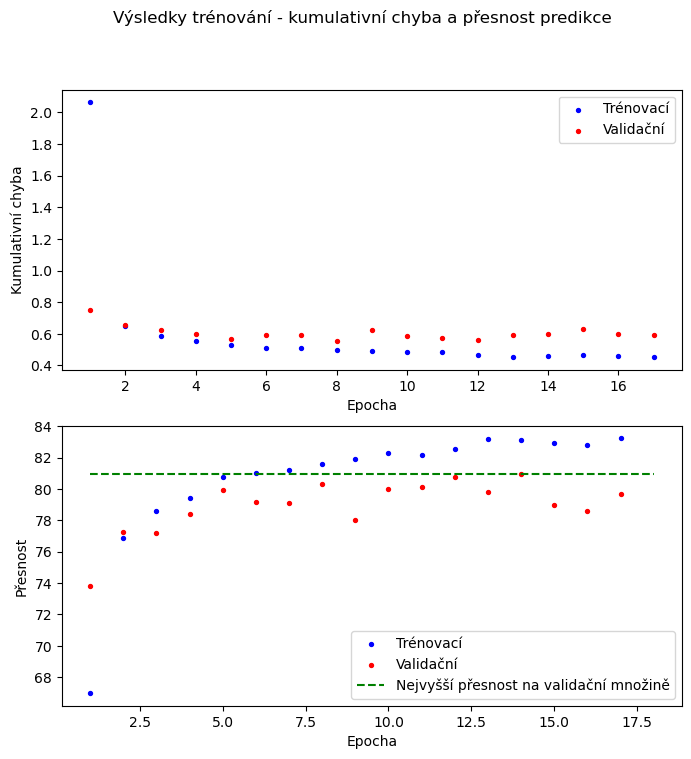

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=20):
  Ztrátová funkce=0.8, Přesnost=79.7%


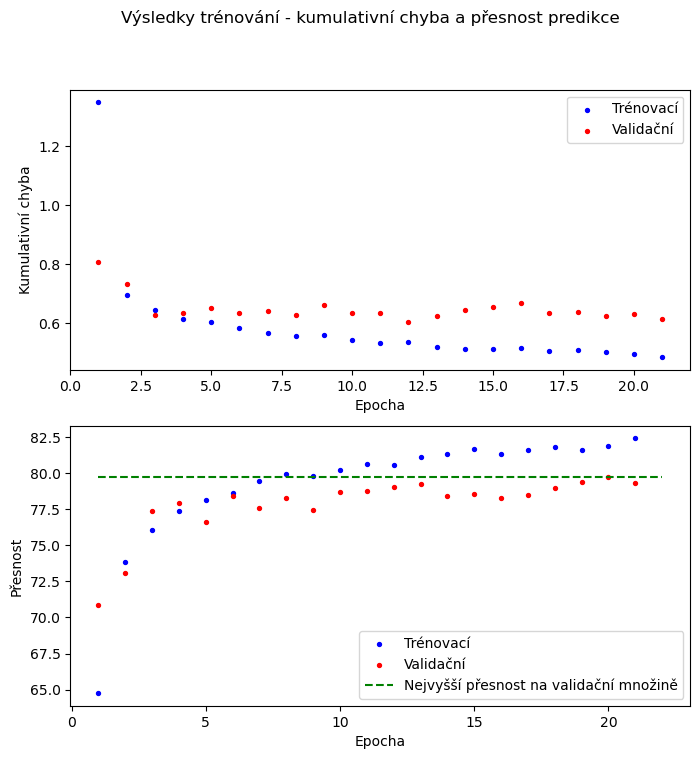

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=49):
  Ztrátová funkce=0.9, Přesnost=81.5%


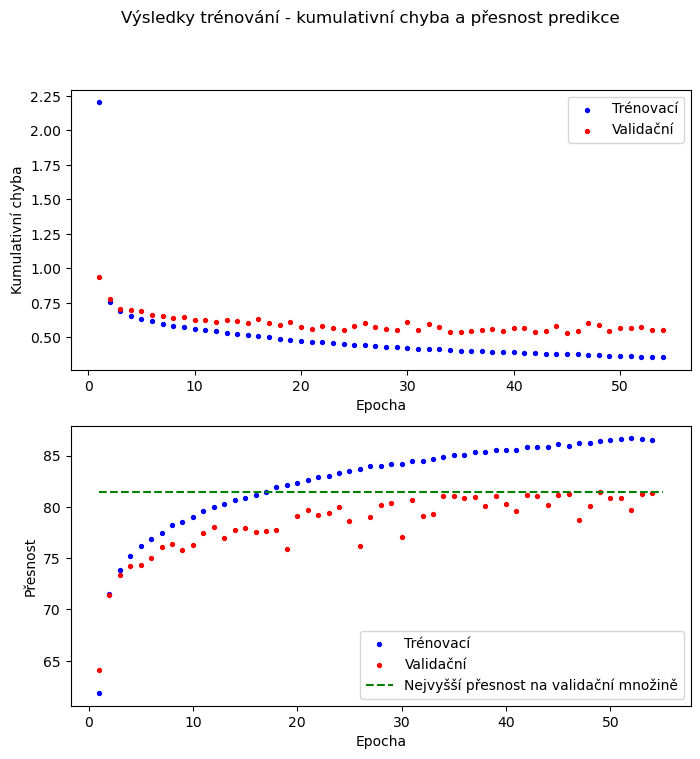

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=37):
  Ztrátová funkce=0.8, Přesnost=80.9%


Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=16):
  Ztrátová funkce=0.8, Přesnost=81.5%


Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=36):
  Ztrátová funkce=0.7, Přesnost=80.8%


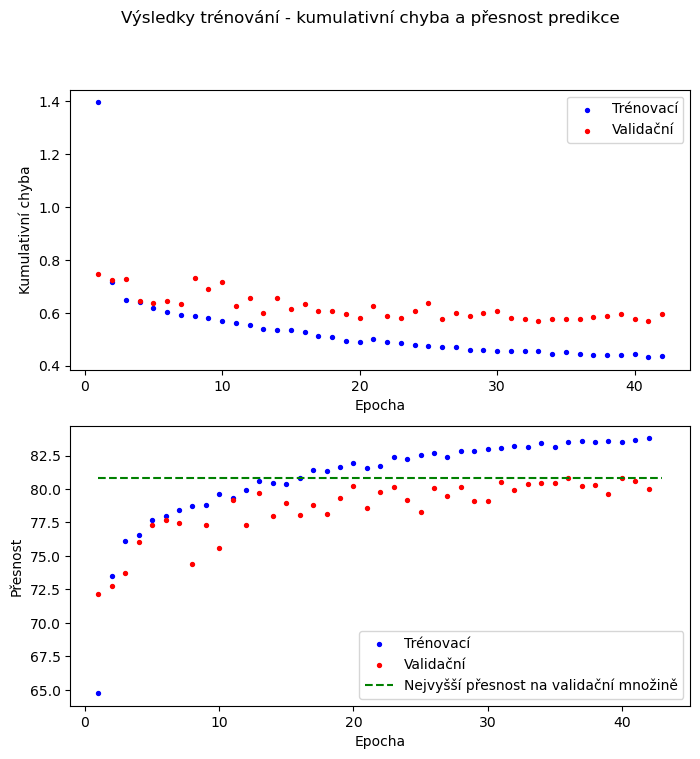

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=24):
  Ztrátová funkce=0.9, Přesnost=80.3%


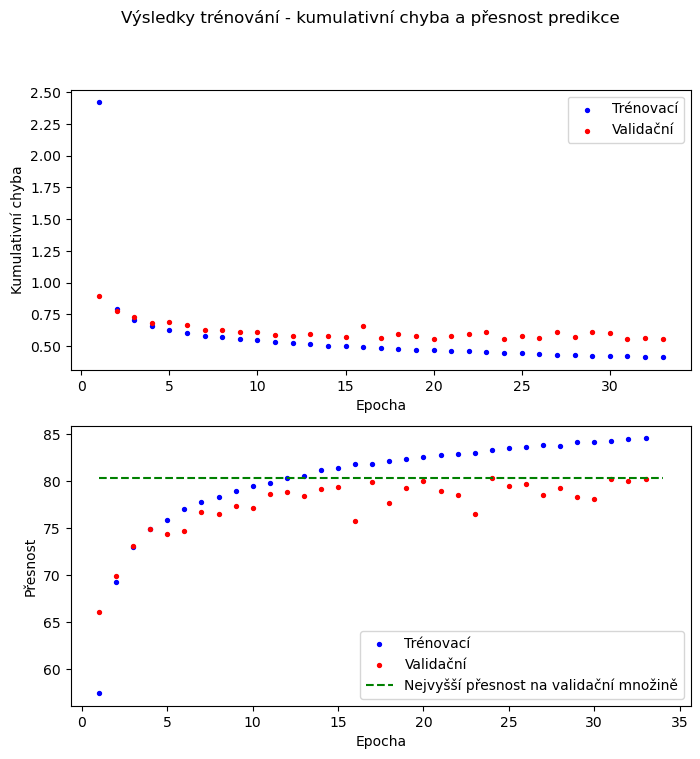

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=34):
  Ztrátová funkce=0.8, Přesnost=80.4%


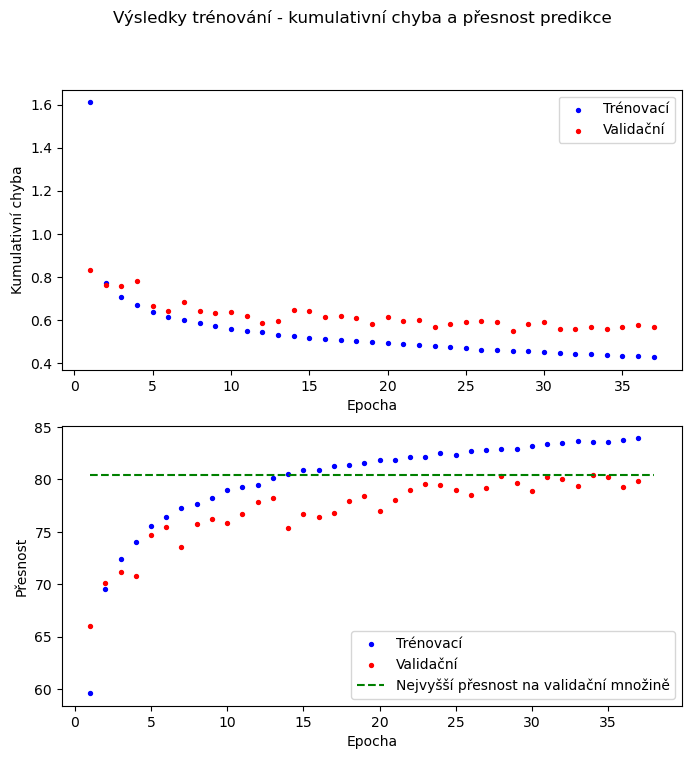

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=13):
  Ztrátová funkce=0.7, Přesnost=81.5%


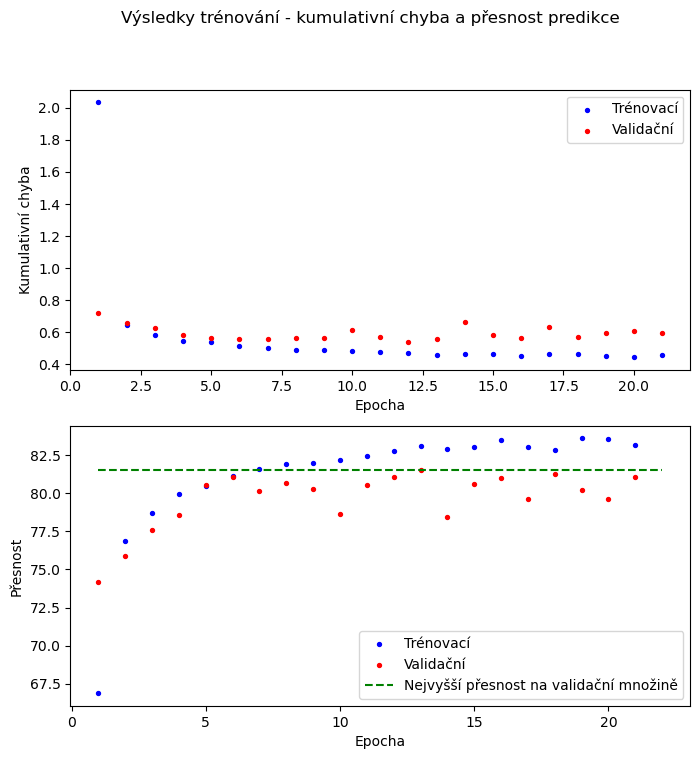

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=39):
  Ztrátová funkce=0.7, Přesnost=81.3%


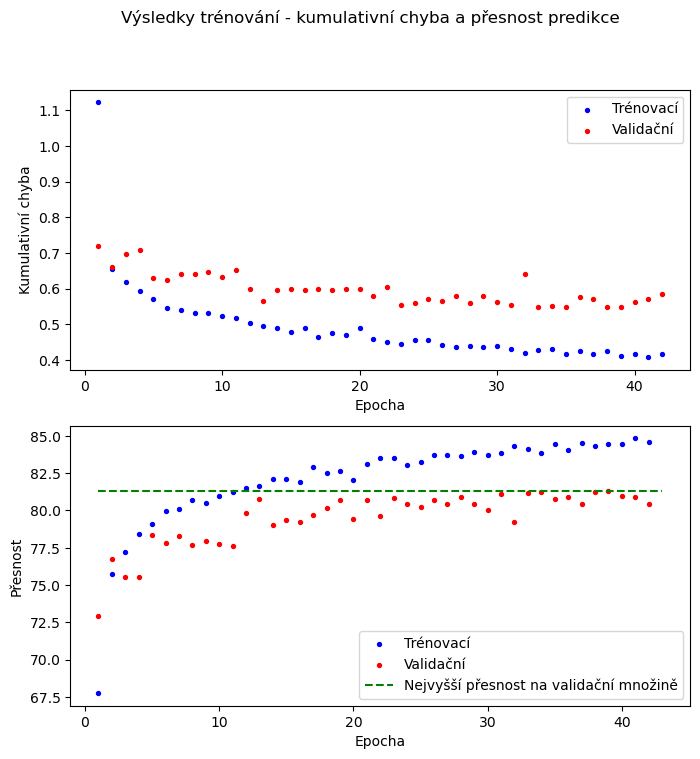

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=37):
  Ztrátová funkce=0.8, Přesnost=81.1%


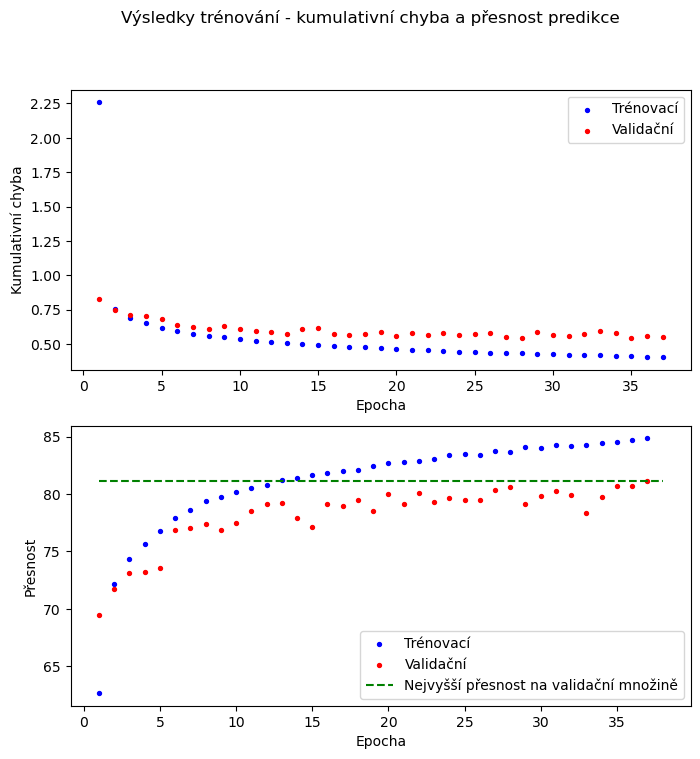

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 128
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=41):
  Ztrátová funkce=0.9, Přesnost=81.3%


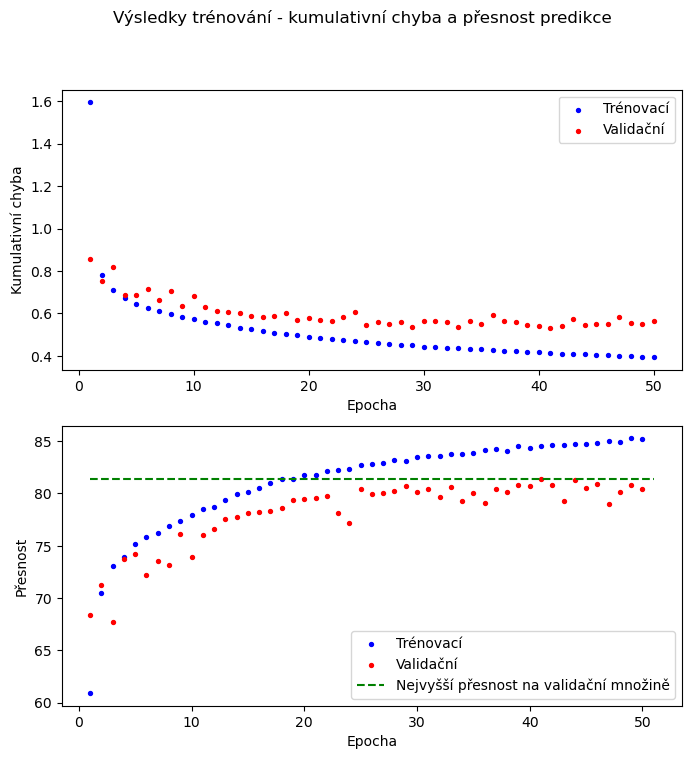

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=10):
  Ztrátová funkce=0.7, Přesnost=81.1%


Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=23):
  Ztrátová funkce=0.7, Přesnost=81.3%


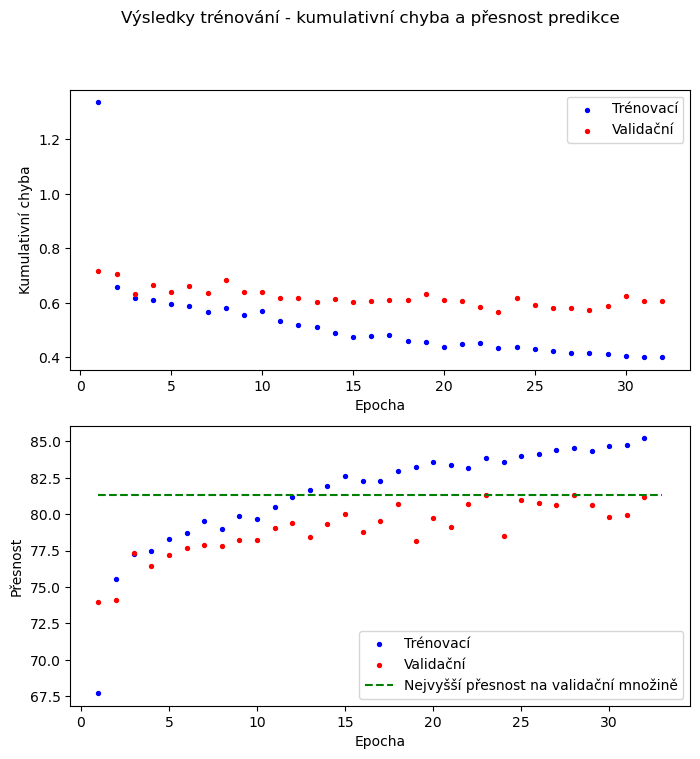

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=47):
  Ztrátová funkce=0.9, Přesnost=82.7%


Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=39):
  Ztrátová funkce=0.8, Přesnost=81.8%


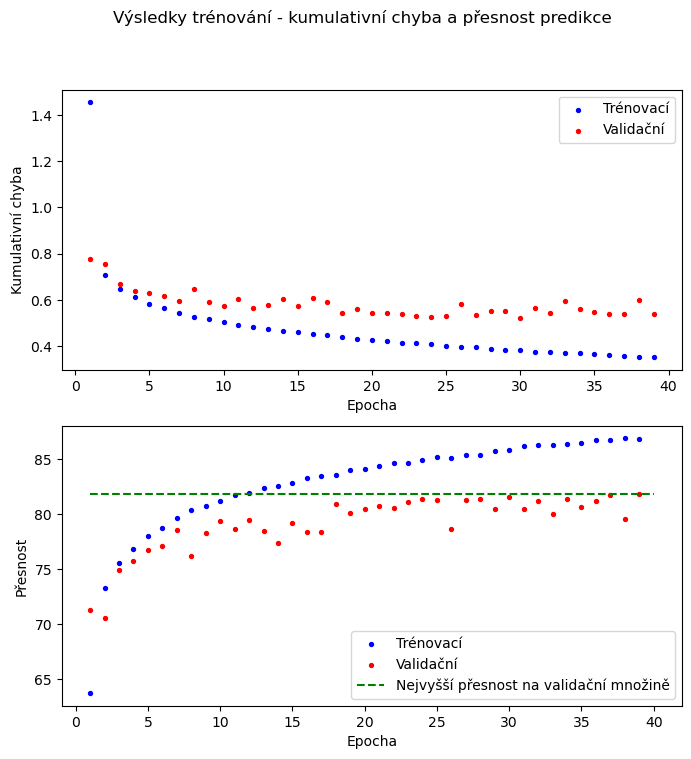

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=14):
  Ztrátová funkce=0.7, Přesnost=80.9%


Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=22):
  Ztrátová funkce=0.8, Přesnost=80.9%


Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=33):
  Ztrátová funkce=0.8, Přesnost=82.0%


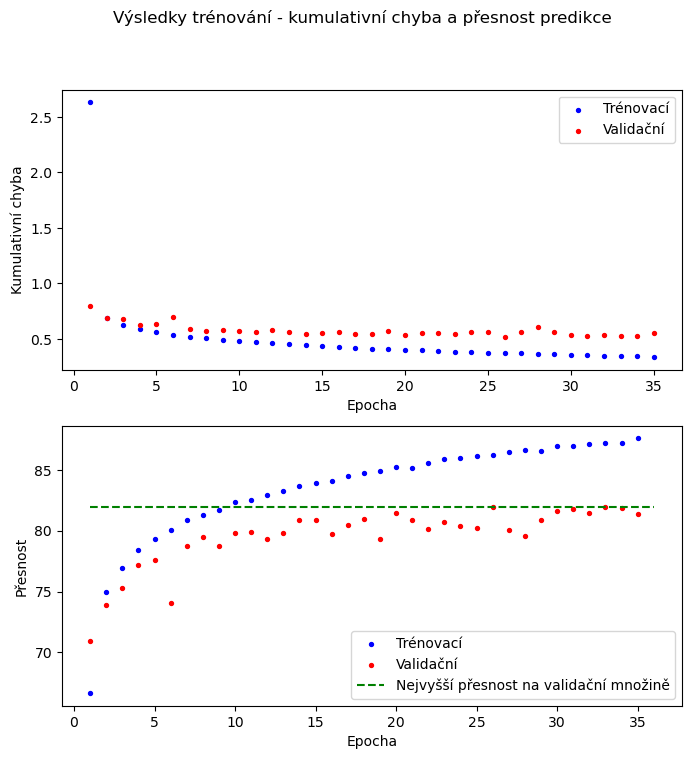

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=35):
  Ztrátová funkce=0.8, Přesnost=82.0%


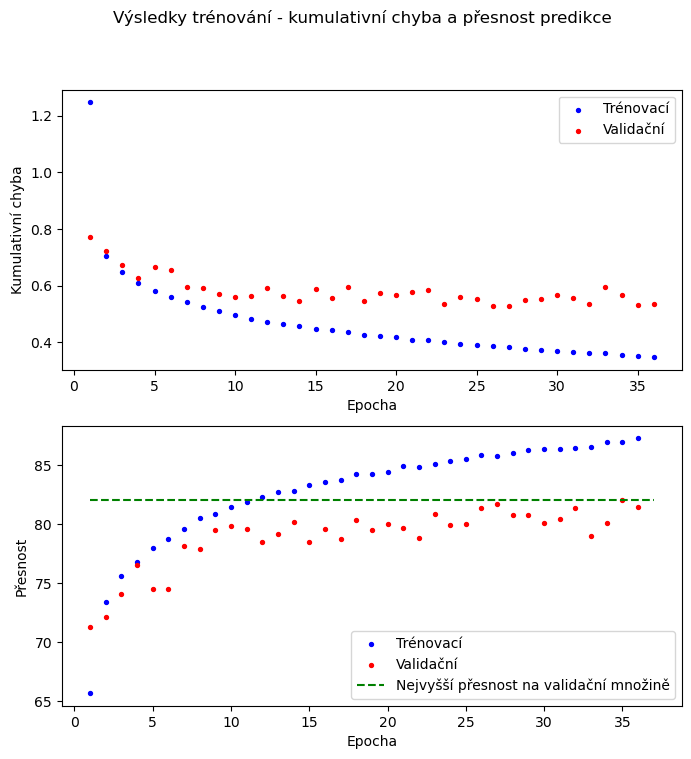

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=9):
  Ztrátová funkce=0.8, Přesnost=81.5%


Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=23):
  Ztrátová funkce=0.8, Přesnost=81.0%


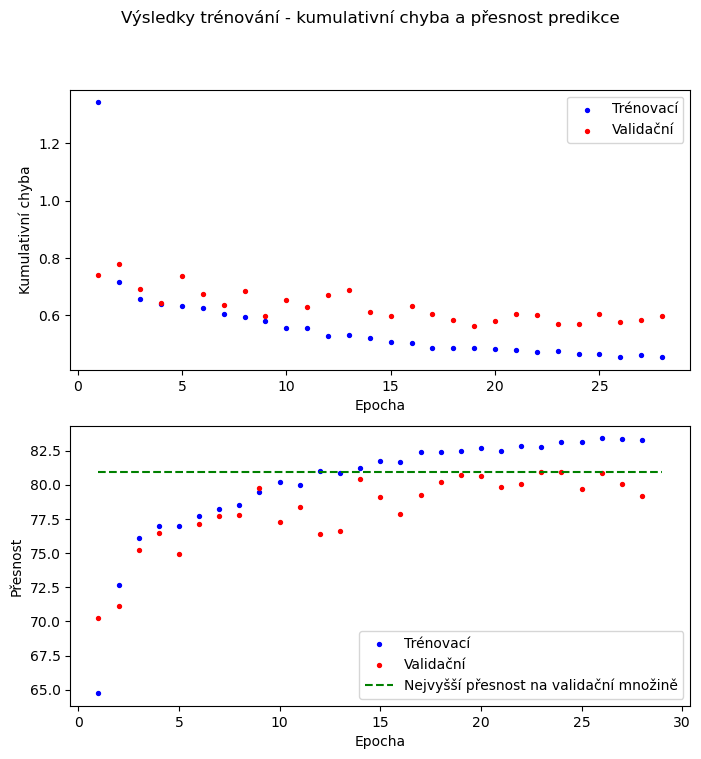

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=37):
  Ztrátová funkce=0.8, Přesnost=83.2%


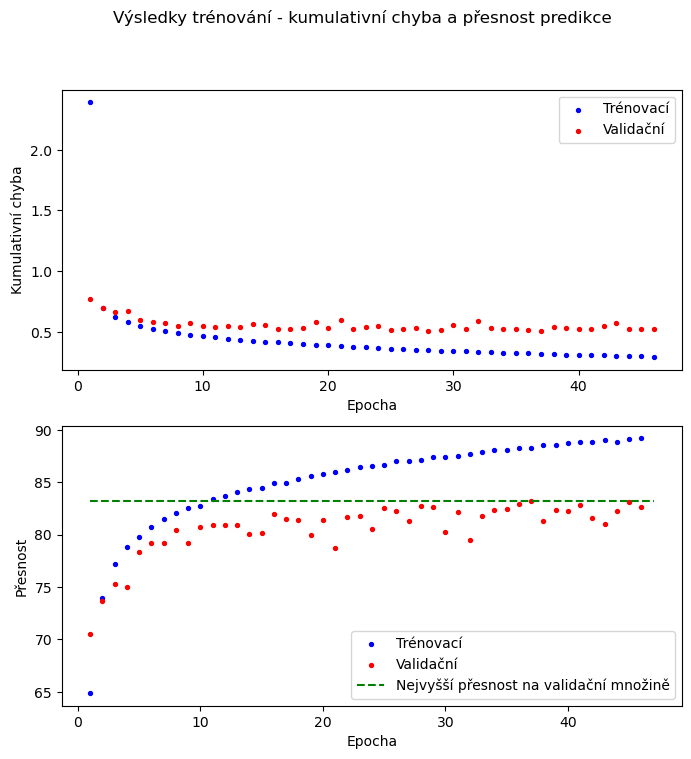

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=28):
  Ztrátová funkce=0.8, Přesnost=81.8%


Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=14):
  Ztrátová funkce=0.7, Přesnost=81.0%


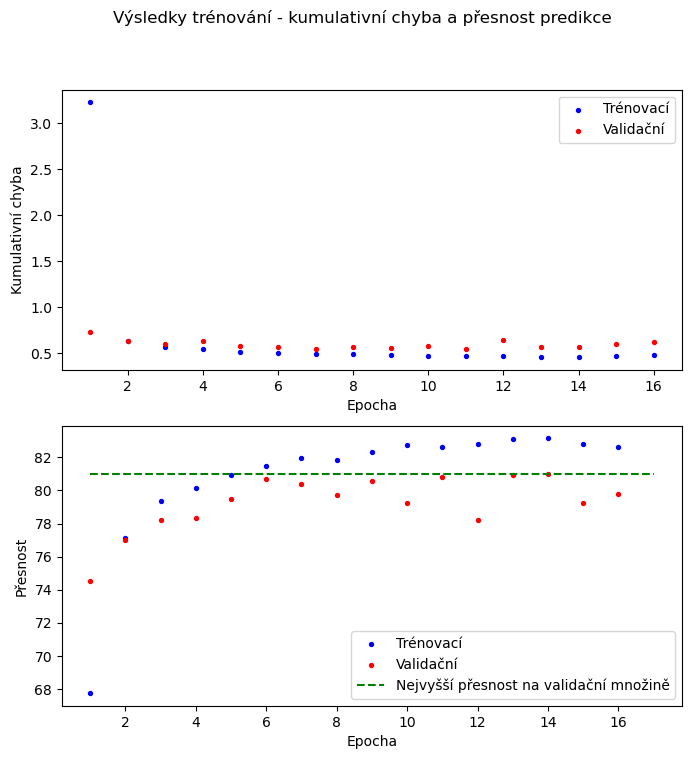

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=40):
  Ztrátová funkce=0.7, Přesnost=81.1%


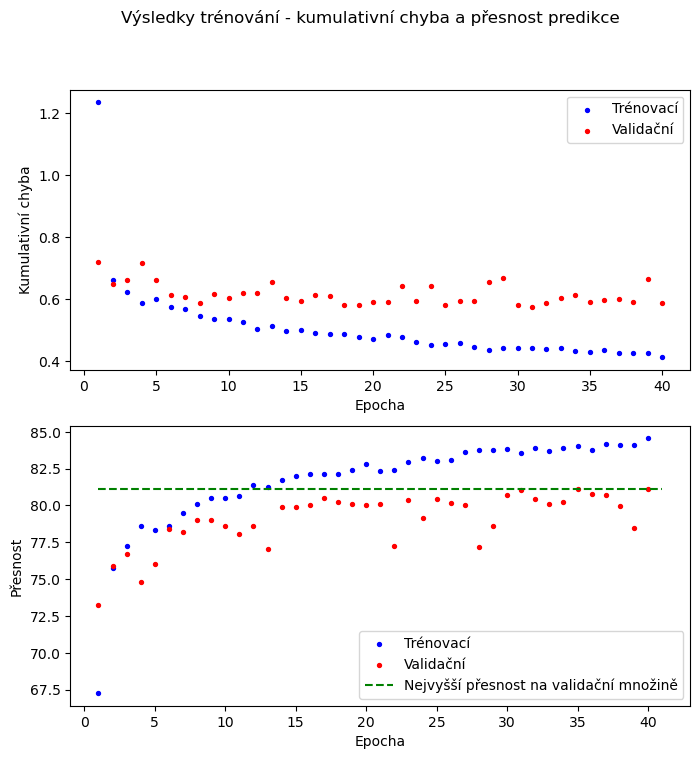

Neuronová síť: <class '__main__.MLPNeuralNetwork'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=34):
  Ztrátová funkce=0.8, Přesnost=82.2%


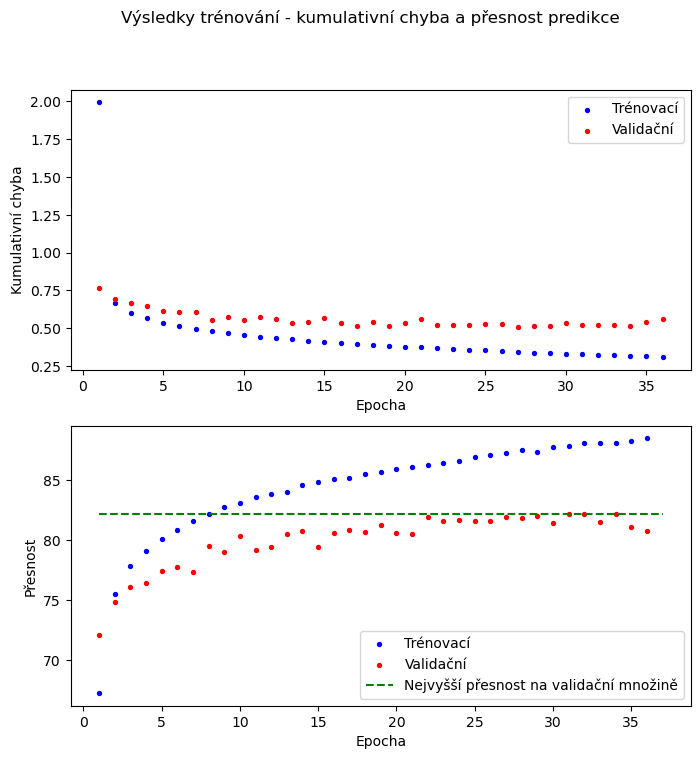

Neuronová síť: <class '__main__.MLPNeuralNetwork2'>
Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
L2 regularizační člen: 0.001
Parametr časného zastavení: 10
Počet neuronů ve vrstvě: 256
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=35):
  Ztrátová funkce=0.8, Přesnost=82.2%


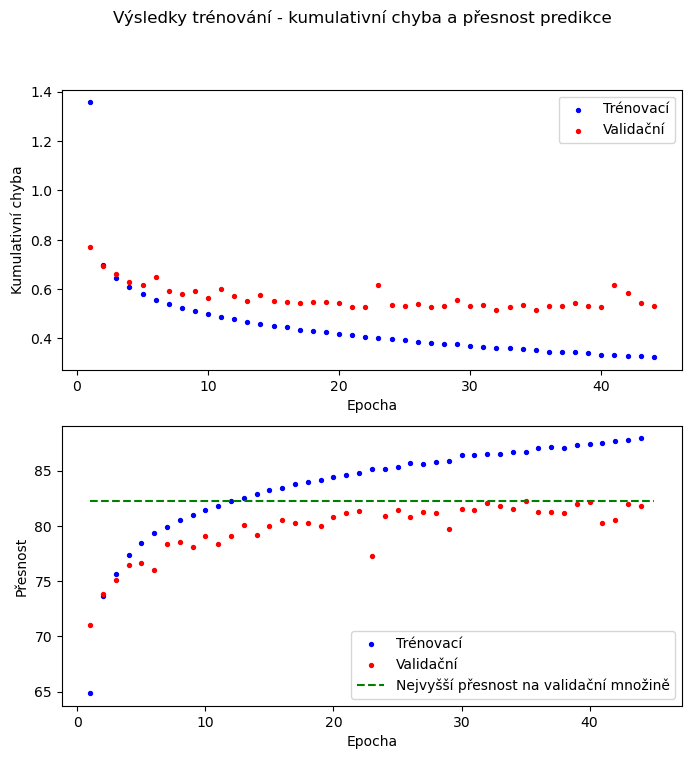

In [28]:
best_acc = None
for batch_size in BATCH_SIZES:
    for neuron_count in NEURON_COUNTS:
        for patience in EARLY_STOPPING_PATIENCE:
            for L2_reg in L2_REGS:
                for hidden in HIDDENS:
                    for opt_method in OPTIMIZERS:
                        for network in MODELS:
                            
                            # příprava
                            model, optimizer, training_loader, validation_loader = init_model_mlp(network, neuron_count, hidden, opt_method, LEARNING_RATE, L2_reg, batch_size)

                            # trénování
                            losses, accs, vlosses, vaccs = train(model, optimizer, LOSS_FN, training_loader, validation_loader, patience, EPOCHS)

                            # získání nejlepšího modelu
                            if not best_acc or np.max(vaccs) > best_acc:
                                best_acc = np.max(vaccs)
                            
                            print(f"Neuronová síť: {network}")
                            print(f"Optimalizační metoda: {opt_method}")
                            print(f"Aktivační funkce: {hidden}")
                            print(f"L2 regularizační člen: {L2_reg}")
                            print(f"Parametr časného zastavení: {patience}")
                            print(f"Počet neuronů ve vrstvě: {neuron_count}")
                            print(f"Velikost dávky: {batch_size}")

                            plot_result(losses, accs, vlosses, vaccs)

Z experimentů jsem zjistil, že konvoluční síť dává lepší výsledky, ale i takto jednoduchá dopředná síť, dává relativně dobré výsledky na validační množině.

In [29]:
print(f"Nejlepší přesnost na validační množině: {best_acc:.1f}%")

Nejlepší přesnost na validační množině: 83.2%


*Než budeme experimentovat s konvoluční neuronovou sítí, připravíme si data do 2D tenzorů.*

In [19]:
# výsledné tensory budou mít rozměry 1 x 32 x 32, kde 32 x 32 je rozměr obrázku a 1 reprezentuje počet barevných kanálů
X_Train_tensor = torch.from_numpy(X_Train.values.reshape(-1, 1, 32, 32).astype('float32')) 
X_Test_tensor = torch.from_numpy(X_Test.values.reshape(-1, 1, 32, 32).astype('float32'))

# převod na tensor dataset
dataset = TensorDataset(X_Train_tensor, y_Train_tensor)

# rozdělení na trénovací a validační data
train_data, val_data = random_split(dataset, [TRAIN_SIZE, 1 - TRAIN_SIZE], random_generator)

# Konvoluční neuronová síť

Opět vytvoříme třídu modelu konvoluční neuronové sítě.

Návrh je složený z dvou podobných vrstev vypadajících takto:
* Konvoluční vrstva rozšiřující kanály z jednoho na 32 a jádrem 3x3. Je přidán padding, který vrátí původní rozměry datasetu.
* Dávková normalizace - zmírňuje problémy hlubokých sítí, vhodná při obrázkových datech, aplikovaná před aktivační funkcí.
* Aktivační funkce - nelineární vrstva.
* Polling vrstva - redukuje rozměry výstupu, vylepšuje invarianci vůči malým posunutím.

Po této konvoluční části následuje plně propojená část, kde se při postupné redukci výstupů přes lineární vrstvy aplikuje také dropout vrstva.

In [20]:
# inspirováno modelem z 10. cvičení a modelem z: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy
class CNNNeuralNetwork(nn.Module):
    def __init__(self, hidden, dropout_prob = 0, batch_norm = False):
        super(CNNNeuralNetwork, self).__init__()
        if batch_norm:
            self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1), # zachování rozměrů (vlivem paddingu), zvýšení počtu kanálů na 32 (32 x 32 x 32)
            nn.BatchNorm2d(32), # dávková normalizace výstupních kanálů
            hidden, # aktivační funkce po aplikaci konvoluční vrstvy
            nn.MaxPool2d(kernel_size = 2, stride = 2) # snížení rozlišení obrázku na polovinu (32 x 16 x 16) - vlivem posuvu indexů (downsampling)
            )
            self.layer2 = nn.Sequential(
                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), # zvýšení počtu kanálů na 64 a snížení velikosti obrázku o 2 (64 x 14 x 14)
                nn.BatchNorm2d(64), # dávková normalizace výstupních kanálů
                hidden, # aktivační funkce po aplikaci konvoluční vrstvy
                nn.MaxPool2d(kernel_size = 2, stride = 2) # opět snížení rozlišení obrázku na polovinu (64 x 7 x 7)
            )
        else: # bez dávkové normalizace
            self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1), # zachování rozměrů (vlivem paddingu), zvýšení počtu kanálů na 32 (32 x 32 x 32)
            hidden, # aktivační funkce po aplikaci konvoluční vrstvy
            nn.MaxPool2d(kernel_size = 2, stride = 2) # snížení rozlišení obrázku na polovinu (32 x 16 x 16) - vlivem posuvu indexů (downsampling)
            )
            self.layer2 = nn.Sequential(
                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), # zvýšení počtu kanálů na 64 a zachování předchozích rozměrů
                hidden, # aktivační funkce po aplikaci konvoluční vrstvy
                nn.MaxPool2d(kernel_size = 2, stride = 2) # opět snížení rozlišení obrázku na polovinu (64 x 8 x 8)
            )

        self.fc1 = nn.Linear(in_features = 64 * 8 * 8, out_features = 512) # aplikace lineární vrstvy s 512 výstupy
        self.dropout = nn.Dropout(dropout_prob) # náhodné vynulování vstupů 
        self.fc2 = nn.Linear(in_features = 512, out_features = 128) # aplikace lineární vrstvy snižující počet výstupů na 128
        self.fc3 = nn.Linear(in_features = 128, out_features = CLASS_COUNT) # konečná lineární vrstva snižující počet výstupů na počet tříd

    def forward(self, x):
        x = self.layer1(x) # první konvoluční vrstva
        x = self.layer2(x) # druhá konvoluční vrstva
        x = x.flatten(start_dim = 1) # příprava rozměru dat na plně propojenou vrstvu
        # lineární vrstvy
        x = self.fc1(x)
        if self.training:
            x = self.dropout(x) # náhodné vynulování výstupů
        x = self.fc2(x)
        x = self.fc3(x)
        return x

*Funkce pro inicializaci konvoluční neuronové sítě, optimizeru a trénovacích dávkovačů*

In [21]:
def init_model_cnn(hidden, dropout_prob, opt_method, learning_rate, L2_reg, batch_size, batch_norm):
    # inicializace modelu
    model = CNNNeuralNetwork(hidden, dropout_prob, batch_norm)

    # inicializace optimalizační metody
    optimizer = opt_method(model.parameters(), lr=learning_rate, weight_decay=L2_reg) # weight_decay ovlivňuje regularizaci L2 normy vah

    # inicializace dávkovačů trénovacích a validačních dat
    training_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # parametr shuffle zamíchá dávku
    validation_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return model, optimizer, training_loader, validation_loader

Opět použijeme `kategorickou relativní entropii` jako účelovou funkci.

In [22]:
LOSS_FN = nn.CrossEntropyLoss() # účelová funkce

Novým hyperparametrem, který by model mohl vylepšovat je pravděpodobnost vynulování výstupů z vrstvy.

Tato regularizační technika by mohla model více generalizovat a zabránit přeučení.

In [23]:
DROPOUT_PROBS = [0, 0.3]

Podobné hyperparametry jako u čistě dopředné neuronové sítě.

*Z výpočetních důvodů jsou některé parametry redukované.*

In [24]:
OPTIMIZERS = [optim.Adam, optim.SGD] # optimalizační metody gradientního sestupu
HIDDENS = [nn.ReLU(), nn.LeakyReLU()] # aktivační funkce skrytých vrstev
BATCH_SIZES = [128, 256] # velikost dávky při trénování
L2_REGS = [0, 0.001] # L2 regularizace - z výpočetních důvodů vynechávám bez regularizace
EARLY_STOPPING_PATIENCE = [4] # velikost tolerované sekvence zhoršování modelu
EPOCHS = 25 # maximální počet epoch

V následující iteraci přes všechny kombinace hyperparametrů budeme trénovat různé modely a evaluovat je.

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=8):
  Ztrátová funkce=0.5, Přesnost=87.8%


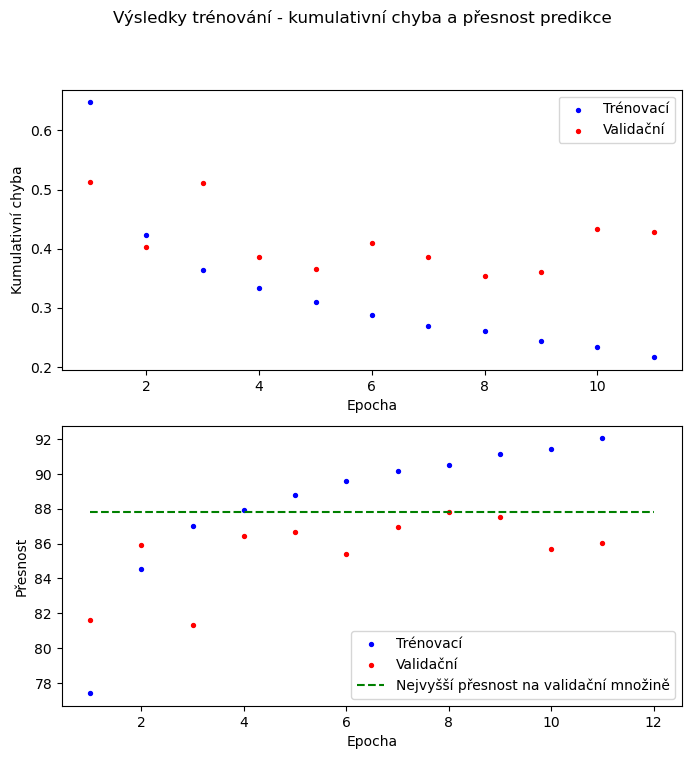

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.3, Přesnost=83.4%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=14):
  Ztrátová funkce=0.5, Přesnost=88.1%


Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.2, Přesnost=83.4%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=15):
  Ztrátová funkce=0.6, Přesnost=86.4%


Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=20):
  Ztrátová funkce=0.6, Přesnost=87.1%


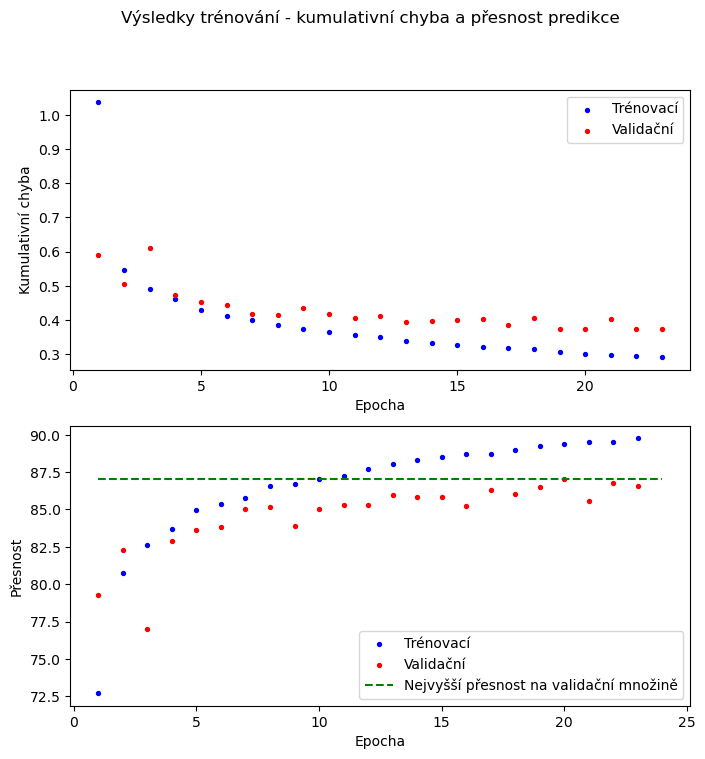

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=11):
  Ztrátová funkce=0.5, Přesnost=86.4%


Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=14):
  Ztrátová funkce=0.6, Přesnost=86.4%


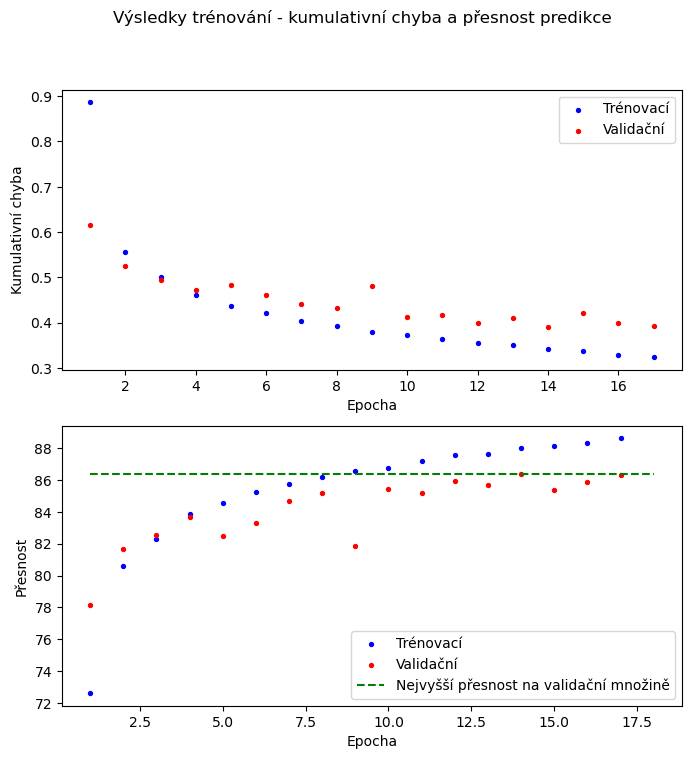

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=8):
  Ztrátová funkce=0.4, Přesnost=88.5%


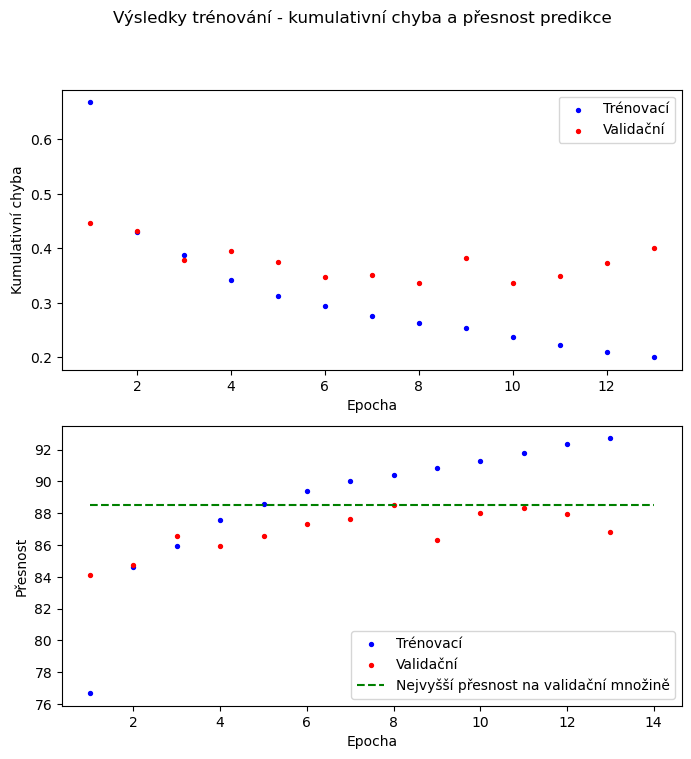

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.2, Přesnost=84.1%


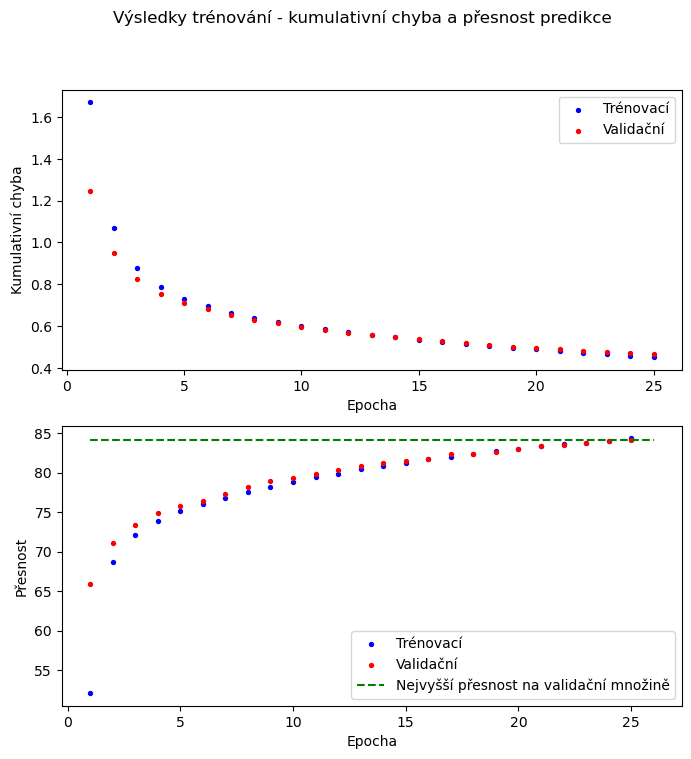

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=7):
  Ztrátová funkce=0.5, Přesnost=88.4%


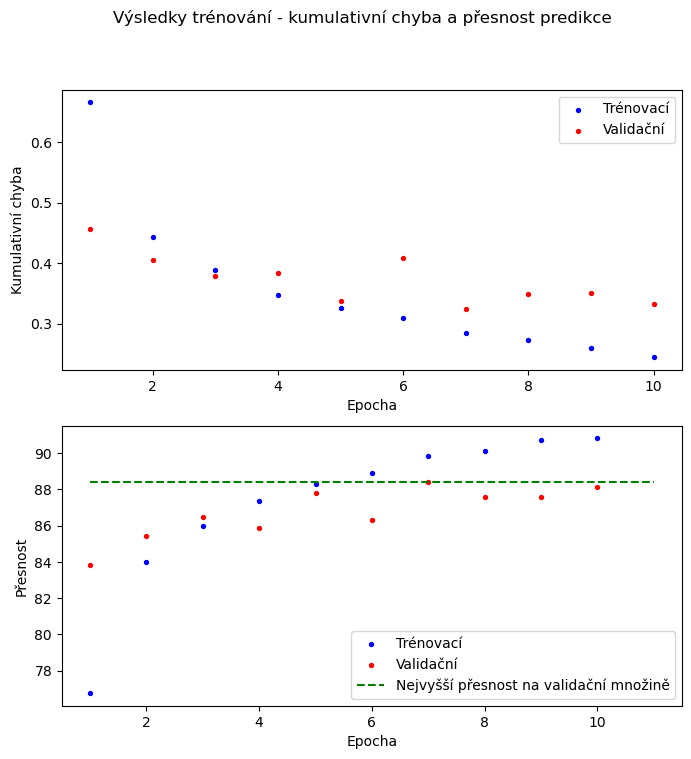

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.3, Přesnost=83.4%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=13):
  Ztrátová funkce=0.5, Přesnost=85.2%


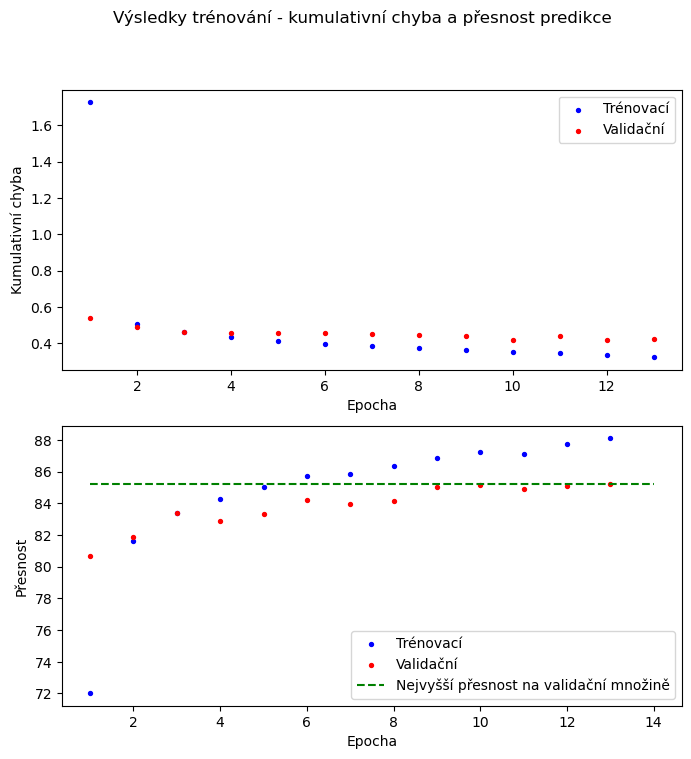

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=21):
  Ztrátová funkce=0.6, Přesnost=87.1%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=15):
  Ztrátová funkce=0.5, Přesnost=87.0%


Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=0.6, Přesnost=87.0%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=13):
  Ztrátová funkce=0.6, Přesnost=88.5%


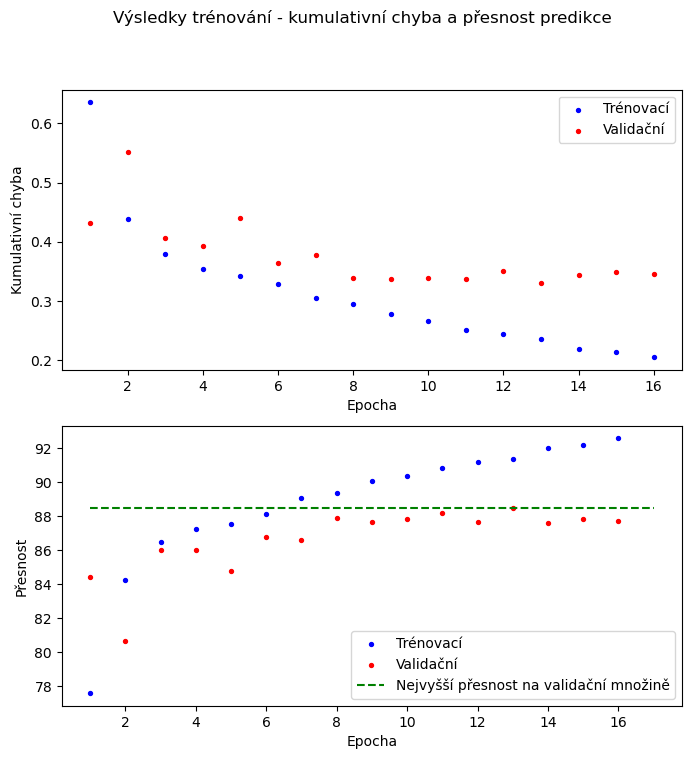

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.2, Přesnost=83.7%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=6):
  Ztrátová funkce=0.6, Přesnost=87.1%


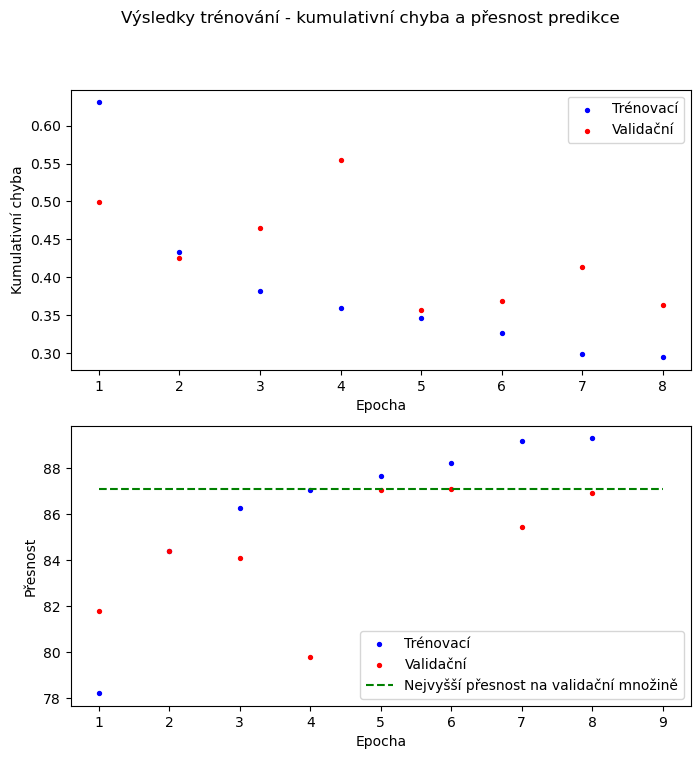

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=24):
  Ztrátová funkce=1.3, Přesnost=83.5%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=17):
  Ztrátová funkce=0.6, Přesnost=86.2%


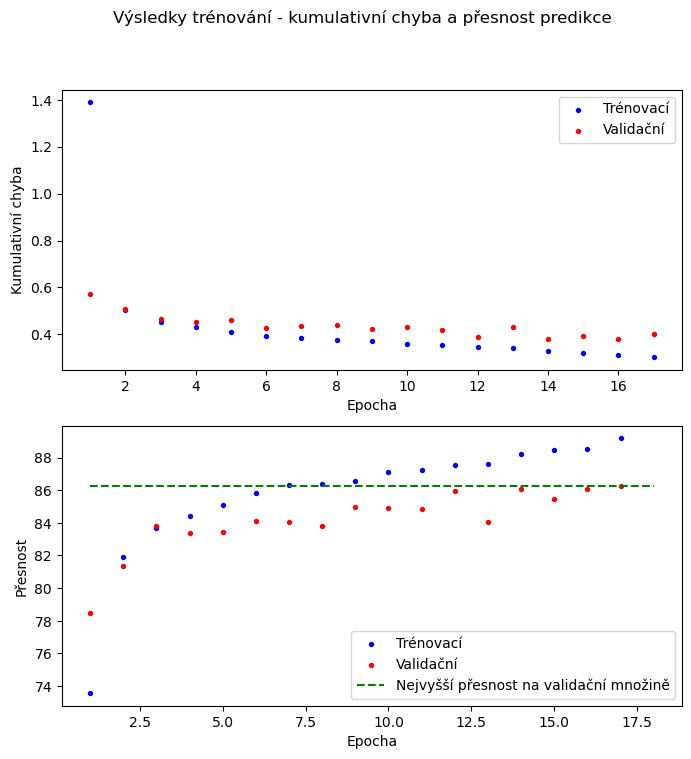

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=13):
  Ztrátová funkce=0.7, Přesnost=86.5%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=6):
  Ztrátová funkce=0.6, Přesnost=85.0%


Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=16):
  Ztrátová funkce=0.6, Přesnost=86.8%


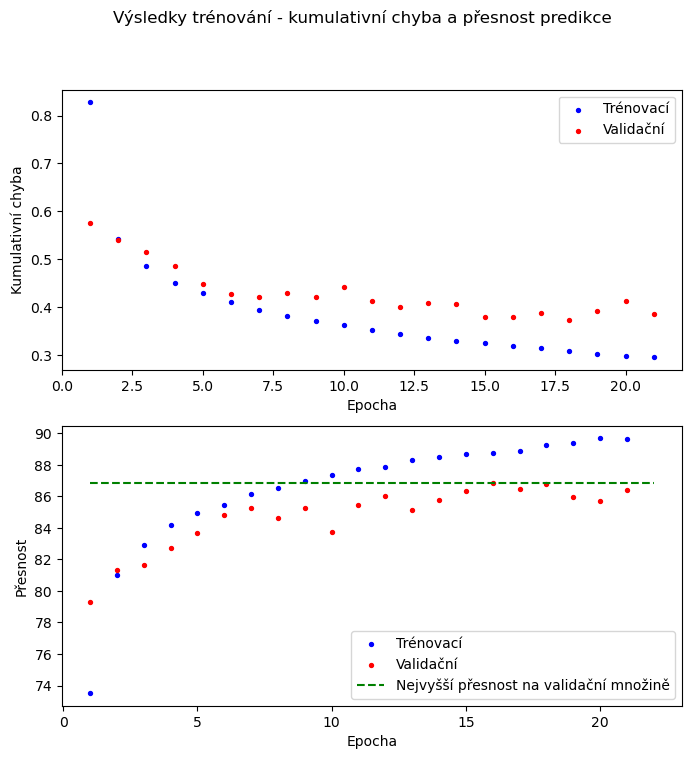

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=7):
  Ztrátová funkce=0.5, Přesnost=88.0%


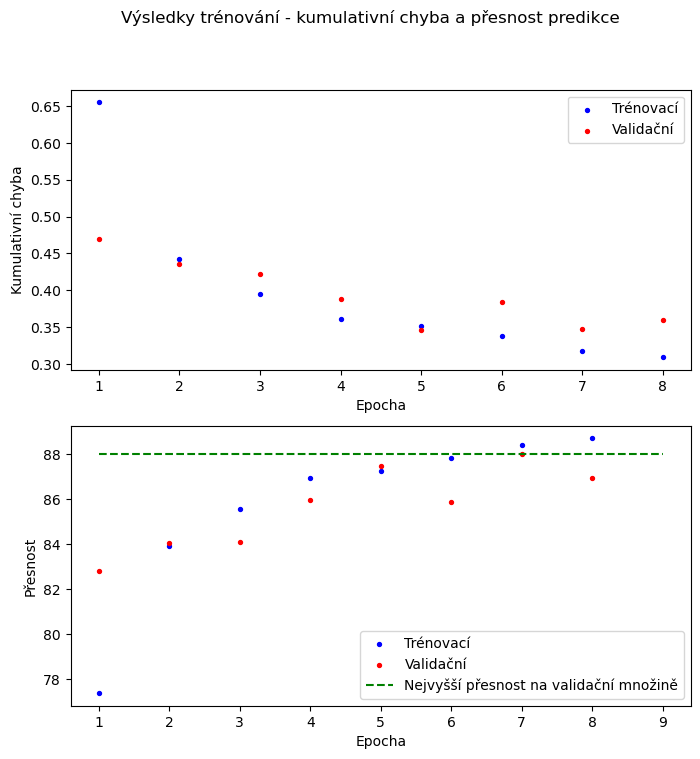

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.3, Přesnost=83.4%


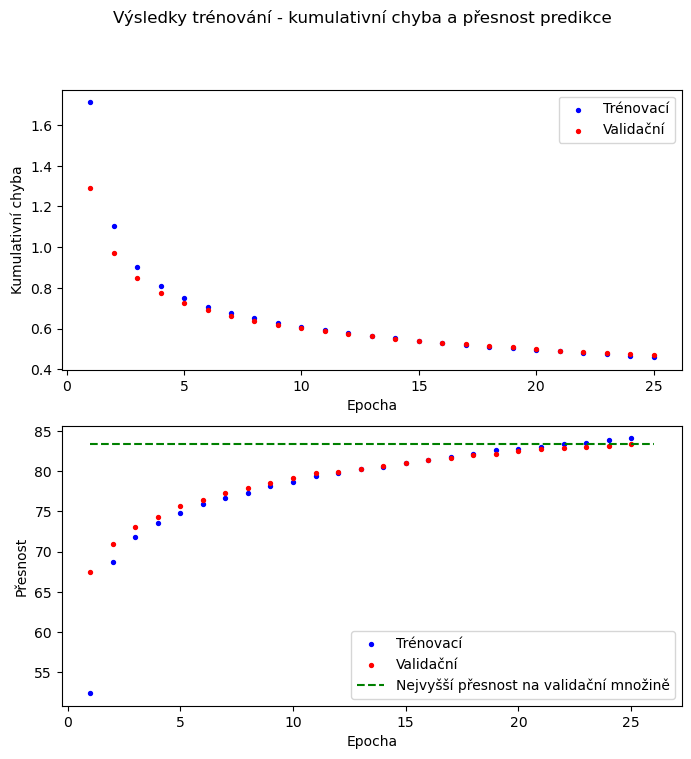

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=21):
  Ztrátová funkce=0.5, Přesnost=88.7%


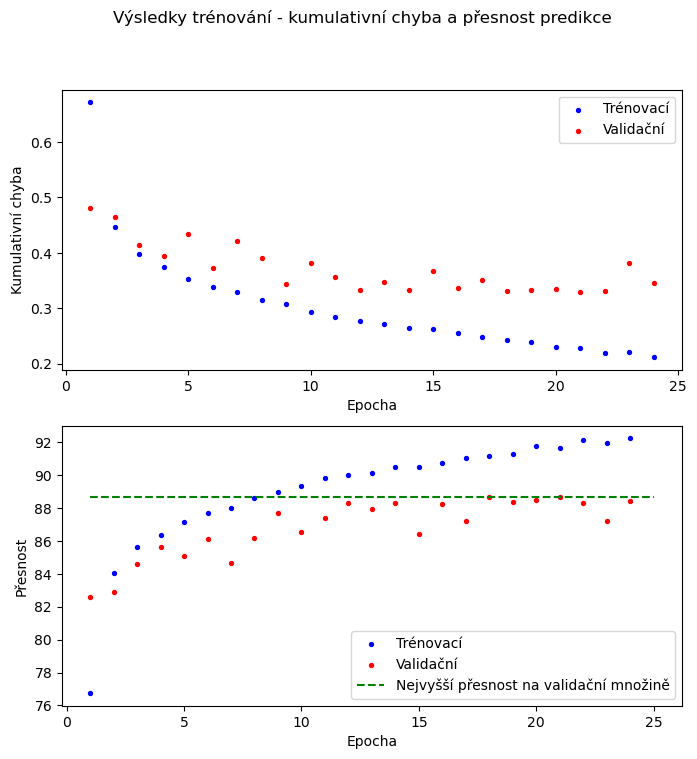

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.3, Přesnost=83.5%


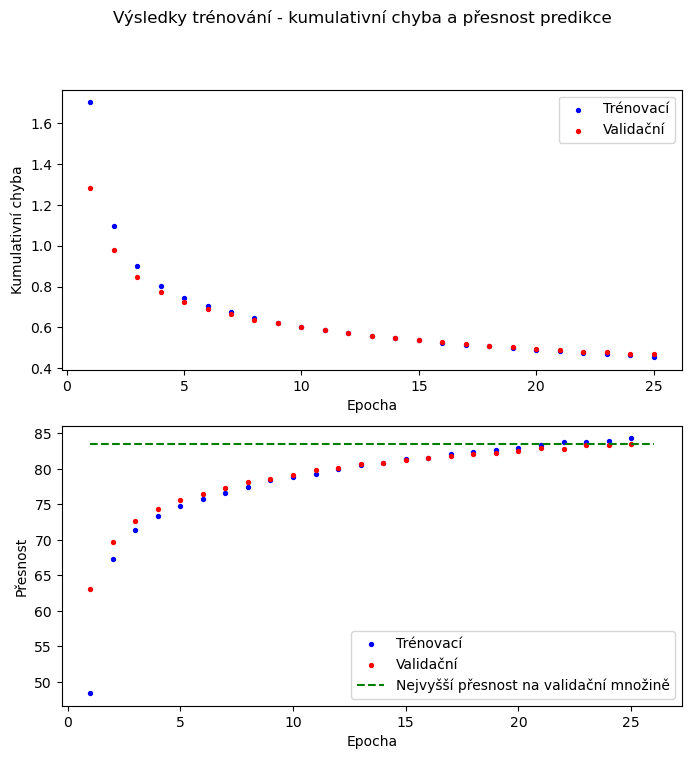

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=13):
  Ztrátová funkce=0.5, Přesnost=86.5%


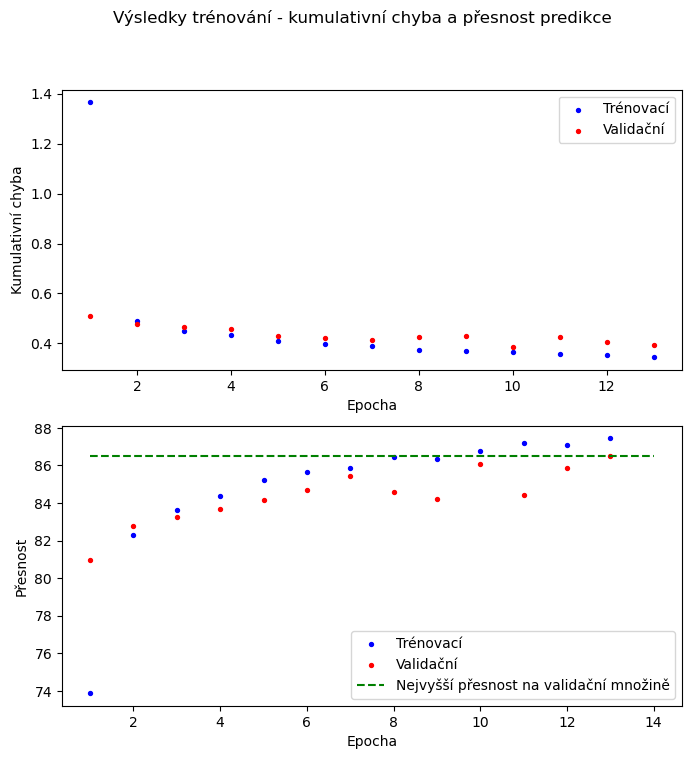

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=21):
  Ztrátová funkce=0.7, Přesnost=86.7%


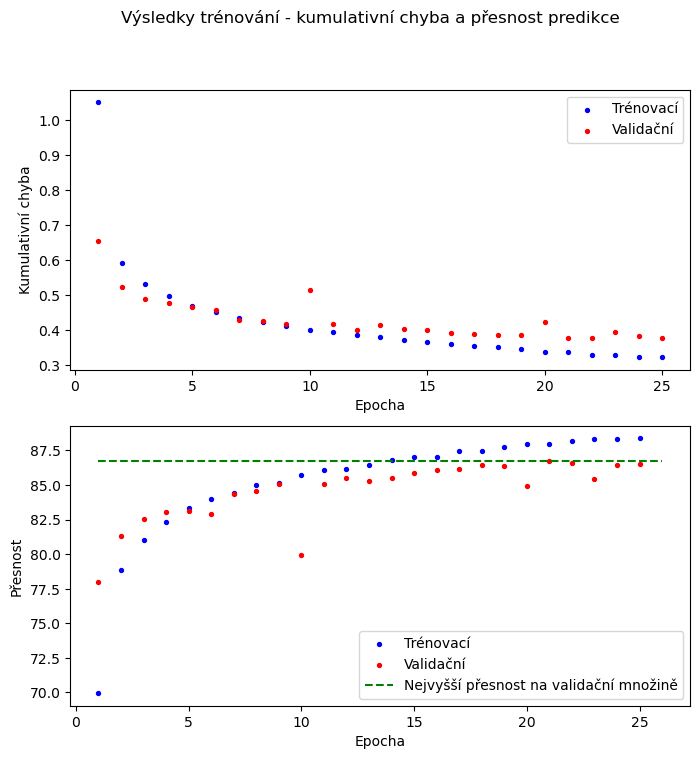

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=10):
  Ztrátová funkce=0.5, Přesnost=86.5%


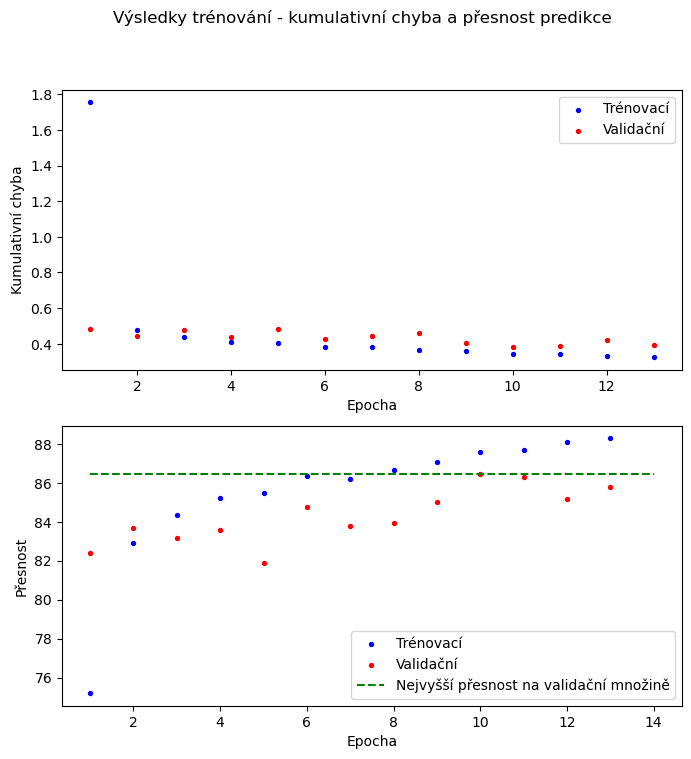

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=15):
  Ztrátová funkce=0.6, Přesnost=86.7%


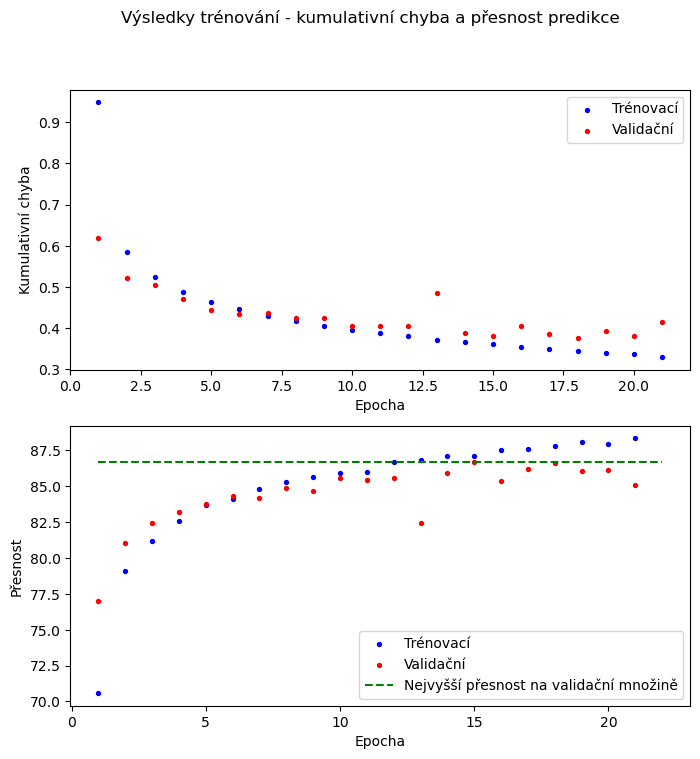

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=10):
  Ztrátová funkce=0.5, Přesnost=88.2%


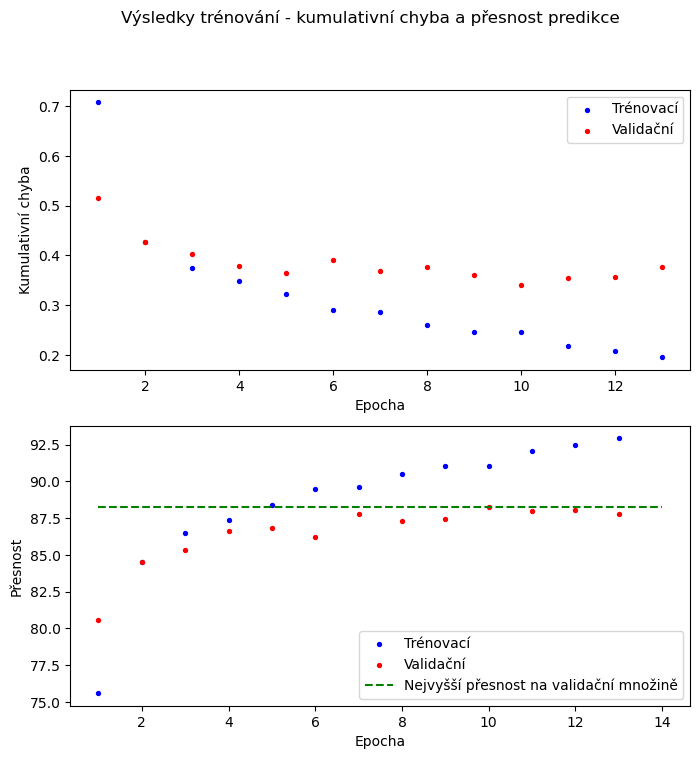

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.7, Přesnost=80.5%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=9):
  Ztrátová funkce=0.5, Přesnost=88.7%


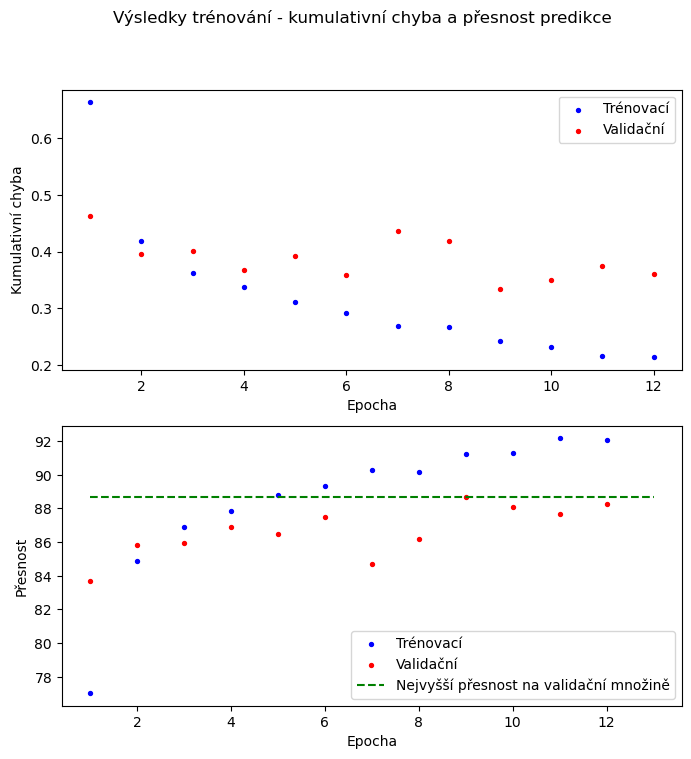

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.6, Přesnost=79.8%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=19):
  Ztrátová funkce=0.6, Přesnost=85.6%


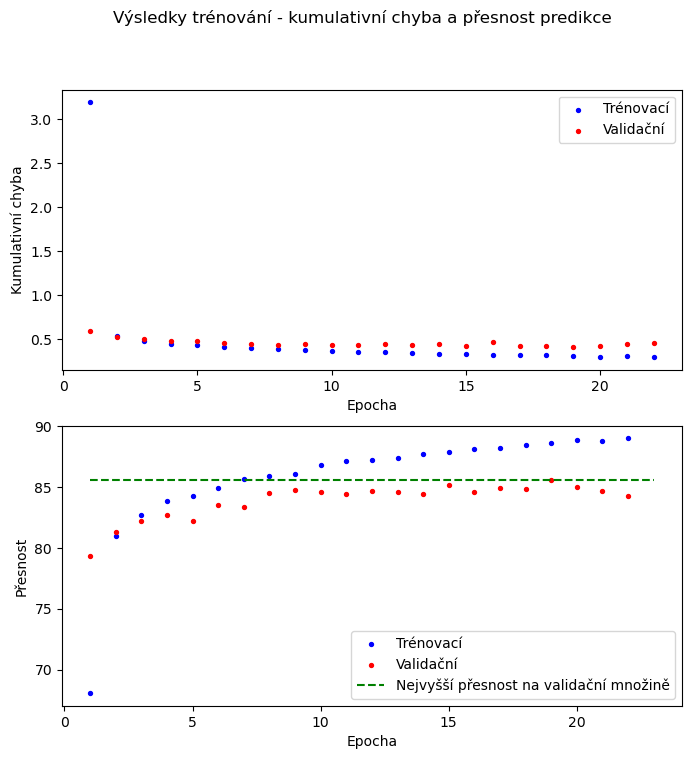

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=22):
  Ztrátová funkce=0.7, Přesnost=86.1%


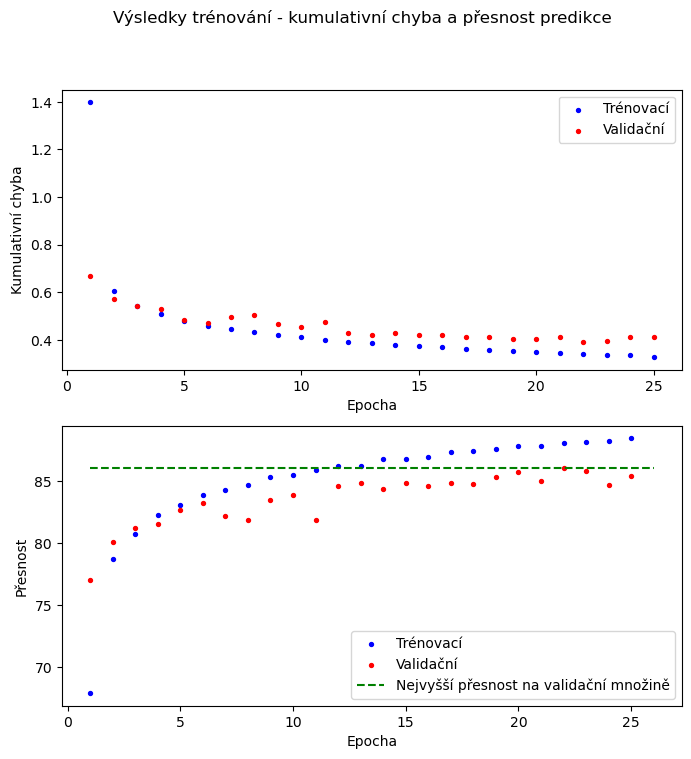

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.5, Přesnost=85.9%


Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=20):
  Ztrátová funkce=0.7, Přesnost=85.9%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=8):
  Ztrátová funkce=0.5, Přesnost=87.5%


Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.7, Přesnost=80.1%


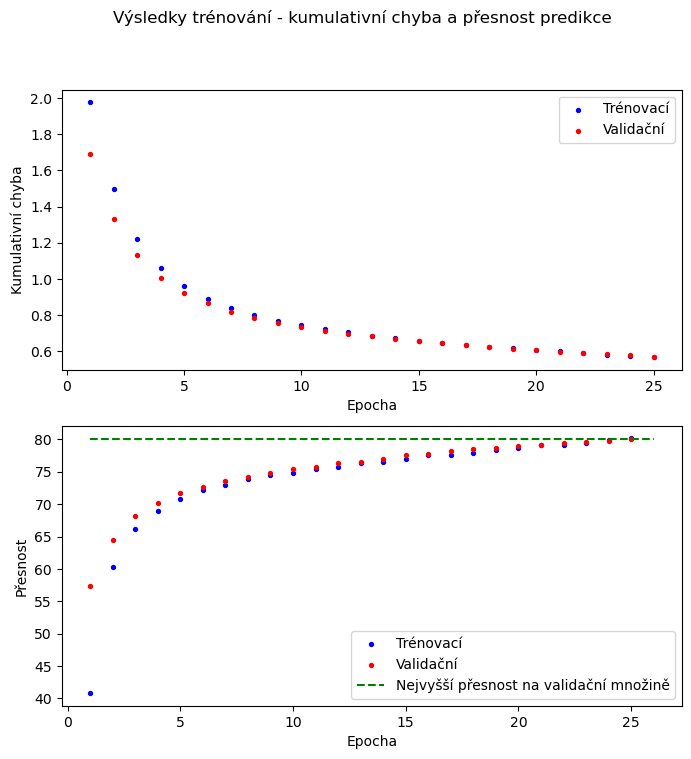

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=10):
  Ztrátová funkce=0.5, Přesnost=88.4%


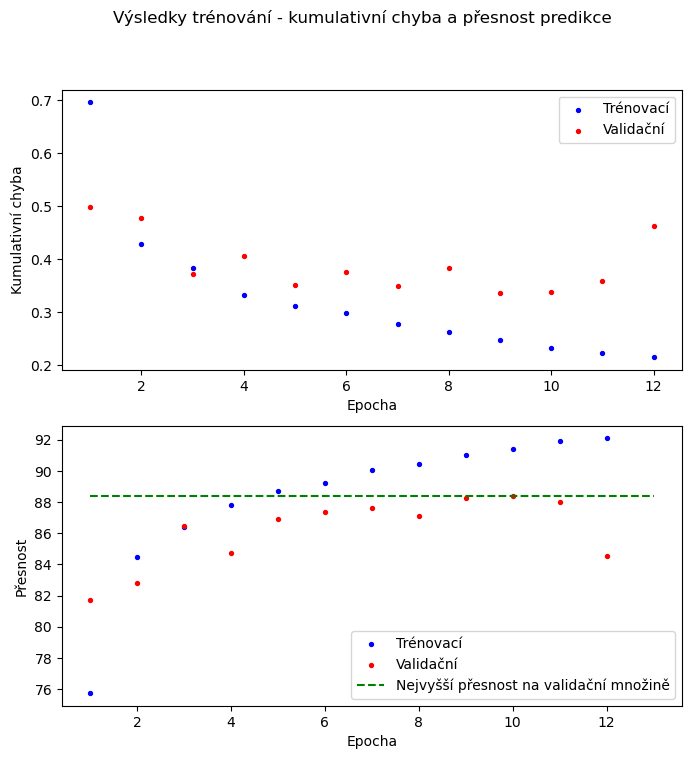

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.6, Přesnost=80.2%


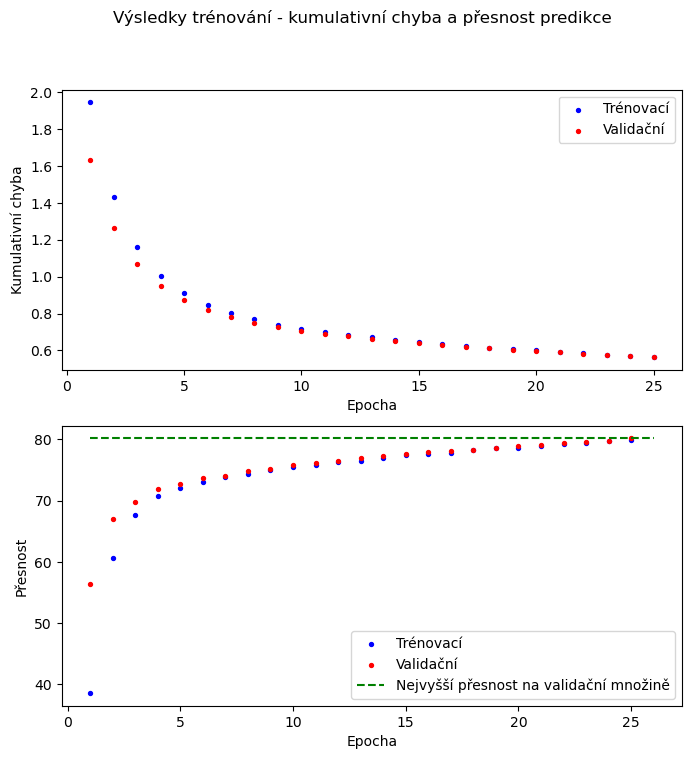

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=15):
  Ztrátová funkce=0.6, Přesnost=85.9%


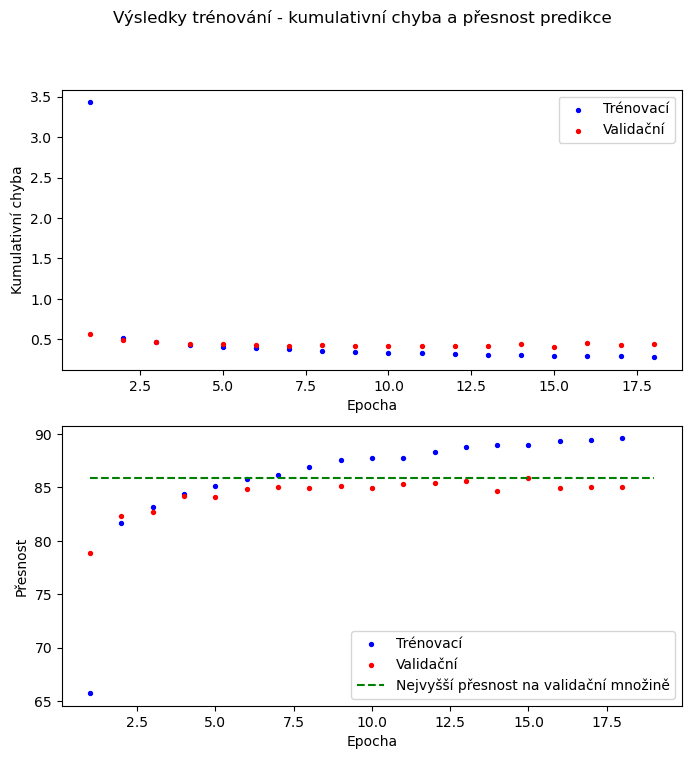

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=23):
  Ztrátová funkce=0.7, Přesnost=86.3%


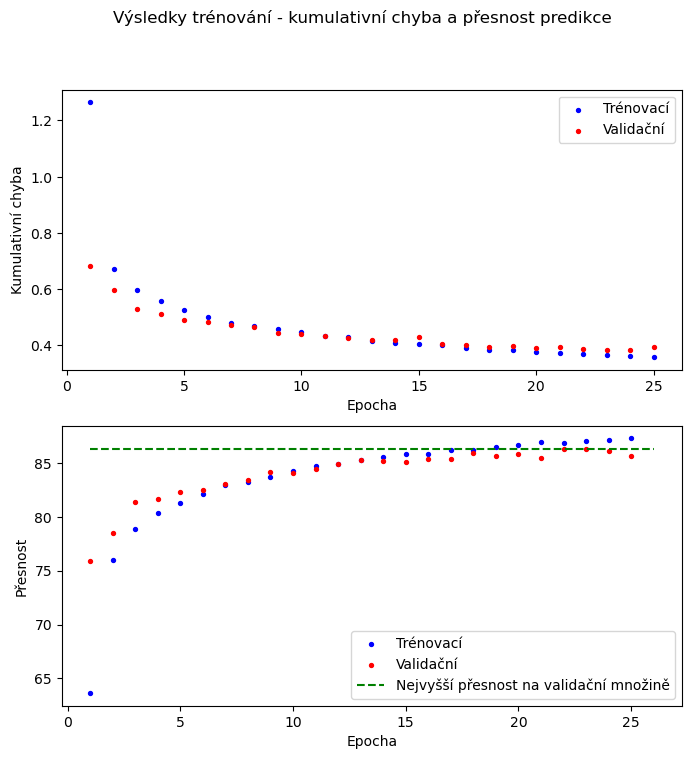

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.5, Přesnost=86.4%


Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=24):
  Ztrátová funkce=0.7, Přesnost=86.1%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=6):
  Ztrátová funkce=0.5, Přesnost=88.4%


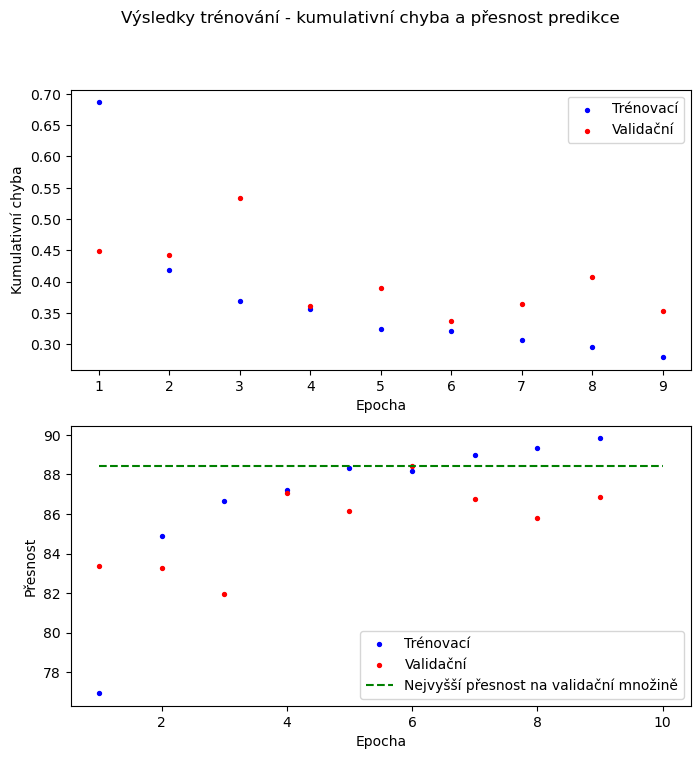

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.7, Přesnost=79.7%


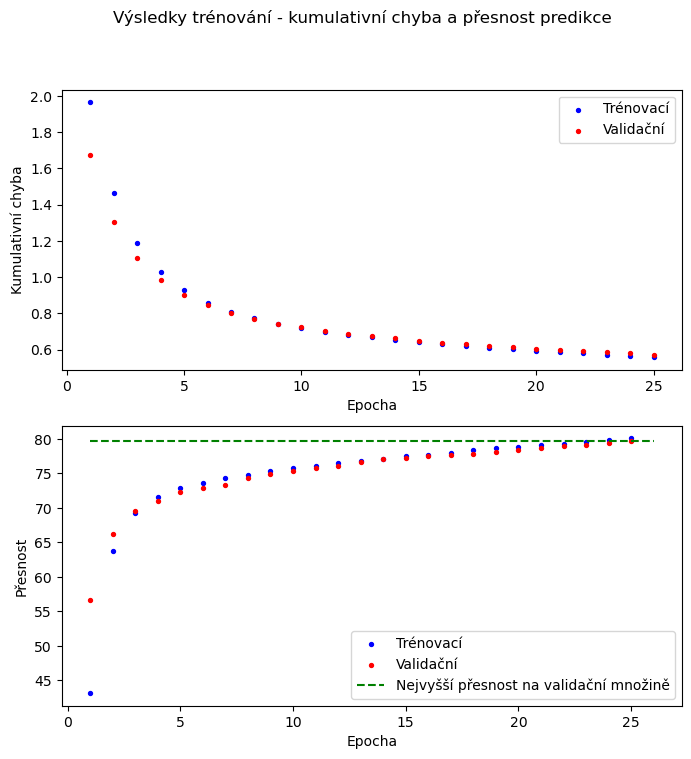

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=7):
  Ztrátová funkce=0.5, Přesnost=87.6%


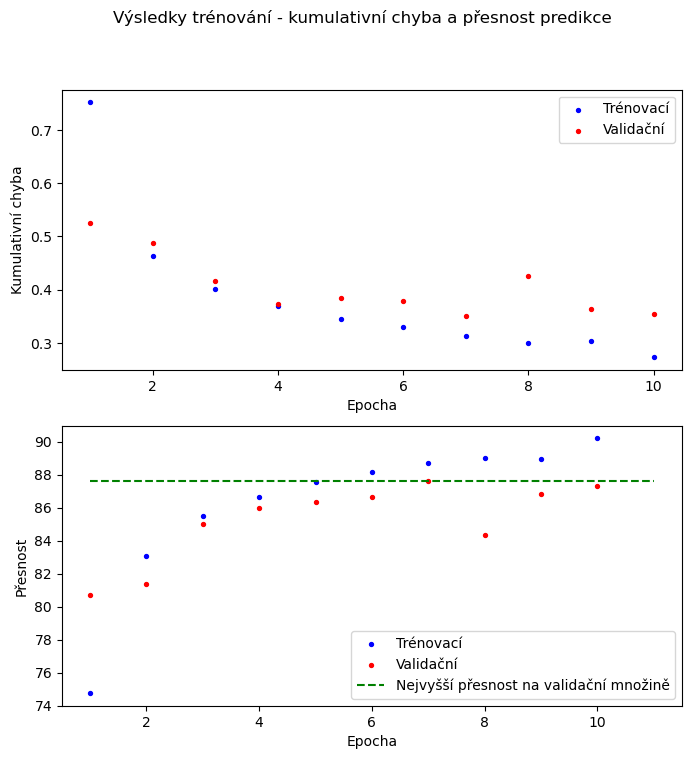

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.7, Přesnost=80.6%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=14):
  Ztrátová funkce=0.6, Přesnost=86.0%


Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=17):
  Ztrátová funkce=0.7, Přesnost=85.5%


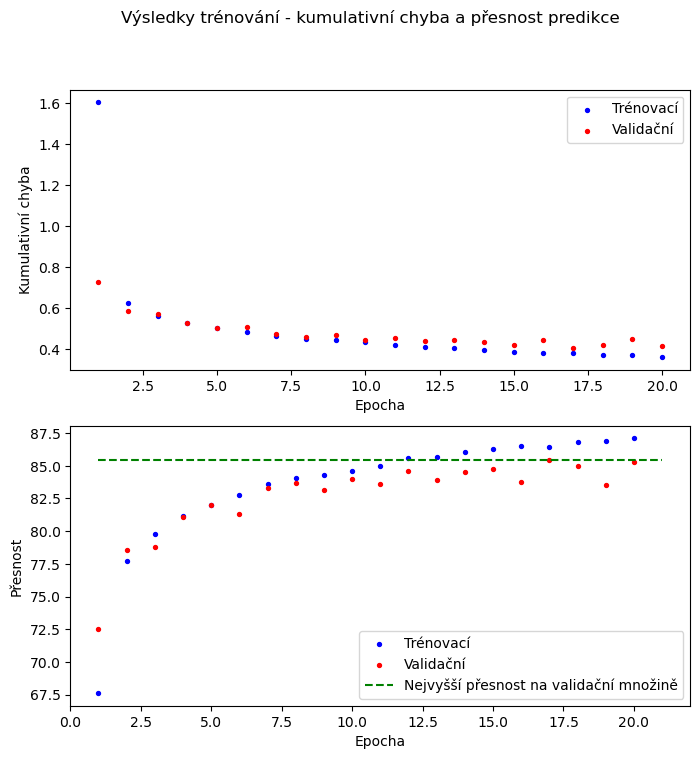

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=8):
  Ztrátová funkce=0.5, Přesnost=85.8%


Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.7, Přesnost=84.9%


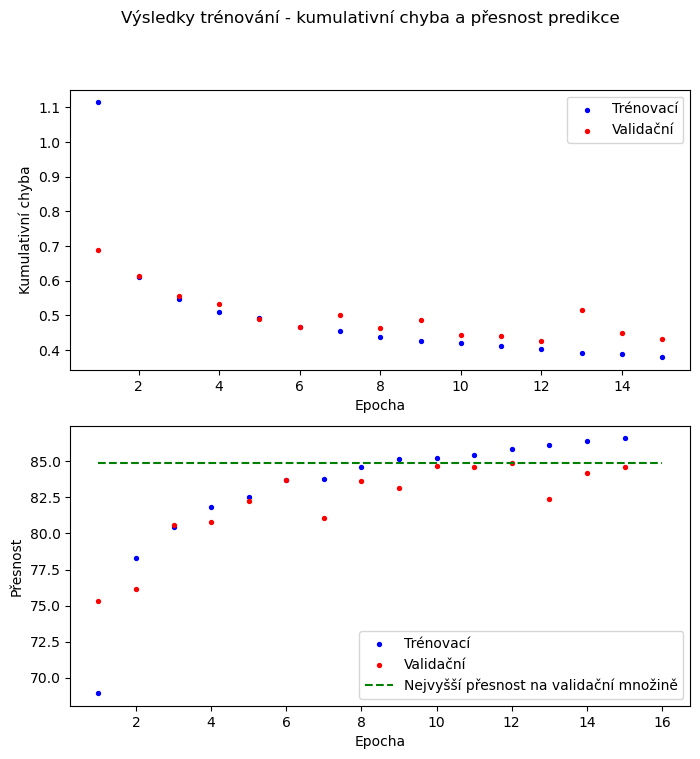

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=7):
  Ztrátová funkce=0.5, Přesnost=87.4%


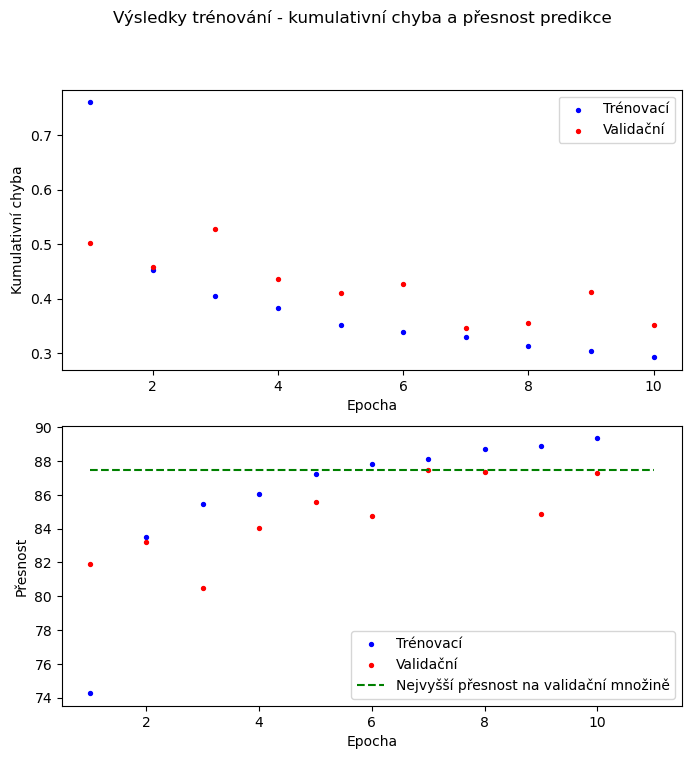

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.5, Přesnost=79.8%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.5, Přesnost=88.3%


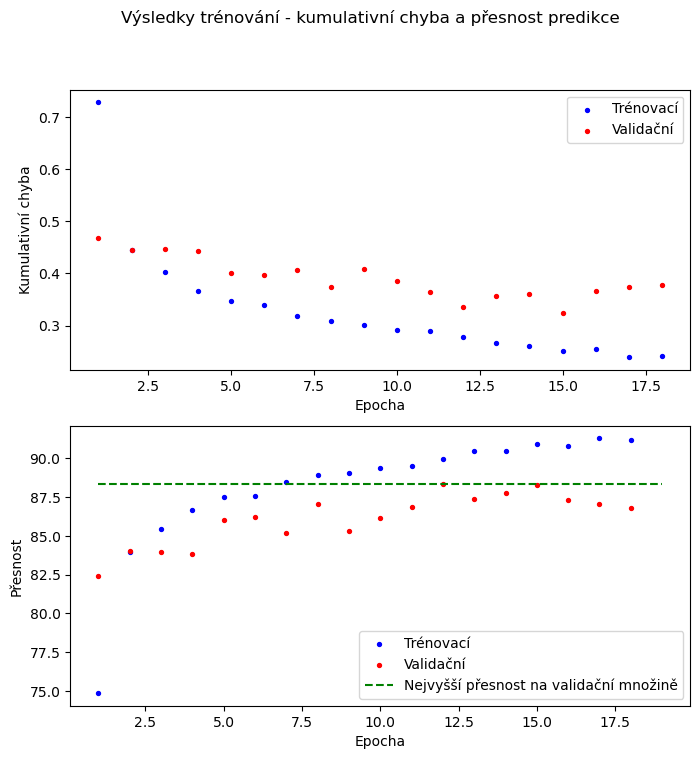

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=25):
  Ztrátová funkce=1.7, Přesnost=80.1%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=7):
  Ztrátová funkce=0.5, Přesnost=85.2%


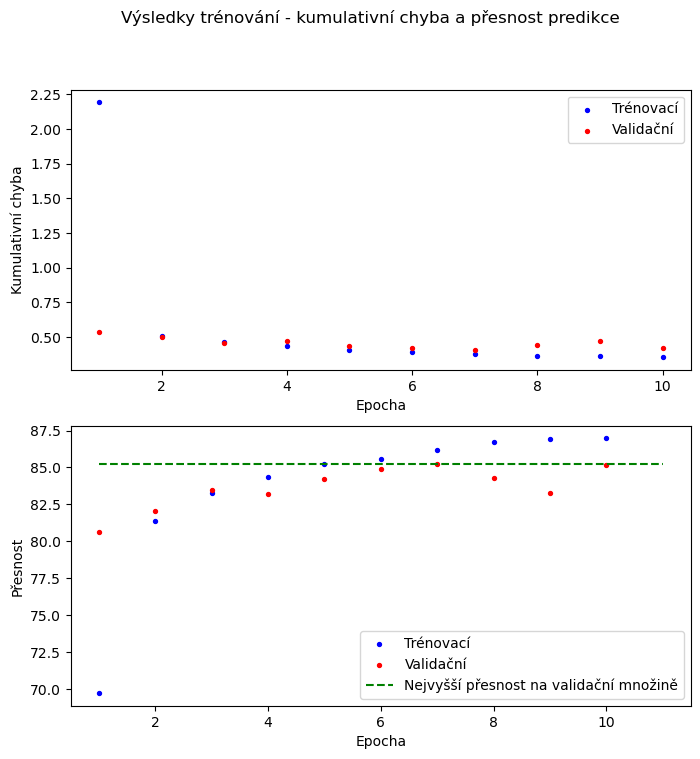

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=24):
  Ztrátová funkce=0.7, Přesnost=86.2%


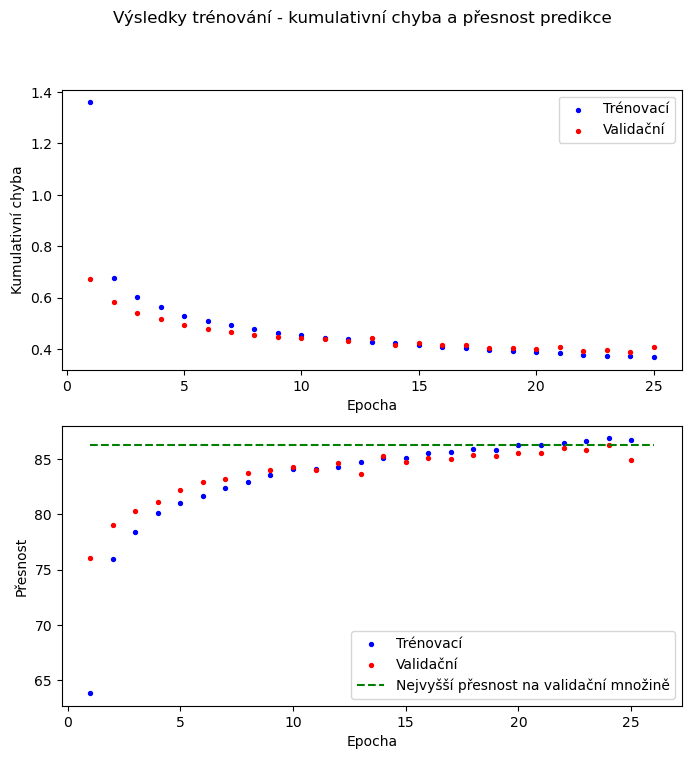

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=9):
  Ztrátová funkce=0.5, Přesnost=85.8%


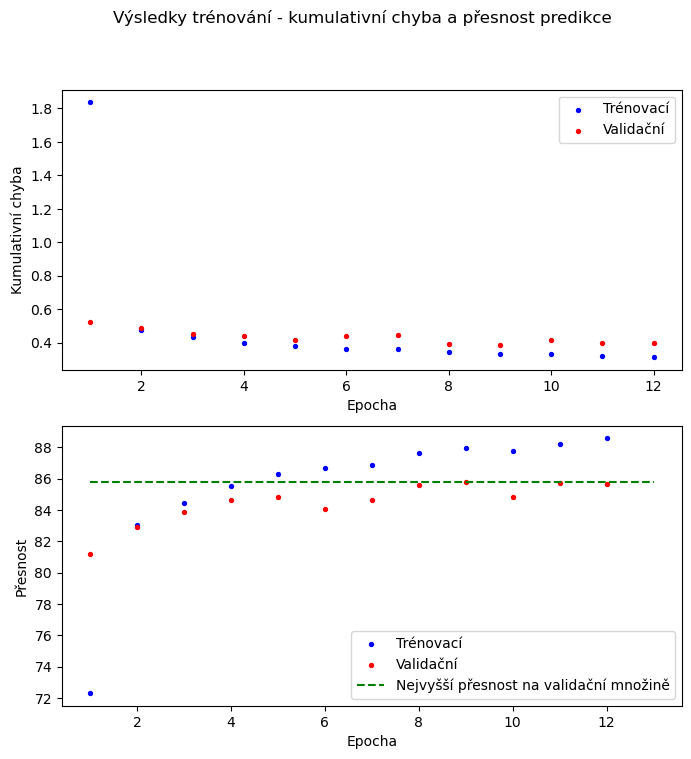

Optimalizační metoda: <class 'torch.optim.sgd.SGD'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=24):
  Ztrátová funkce=0.6, Přesnost=86.2%


In [36]:
for patience in EARLY_STOPPING_PATIENCE:
    for batch_size in BATCH_SIZES:
        for L2_reg in L2_REGS:
            for dropout_prob in DROPOUT_PROBS:
                for batch_norm in [True, False]:
                    for hidden in HIDDENS:
                        for opt_method in OPTIMIZERS:
                            # příprava
                            model, optimizer, training_loader, validation_loader = init_model_cnn(hidden, dropout_prob, opt_method, LEARNING_RATE, L2_reg, batch_size, batch_norm)

                            # trénování
                            losses, accs, vlosses, vaccs = train(model, optimizer, LOSS_FN, training_loader, validation_loader, patience, EPOCHS)

                            # získání nejlepšího modelu
                            if not best_acc or np.max(vaccs) > best_acc:
                                final_model = model
                                best_acc = np.max(vaccs)

                            print(f"Optimalizační metoda: {opt_method}")
                            print(f"Aktivační funkce: {hidden}")
                            print(f"Dávková normalizace: {batch_norm}")
                            print(f"Pravděpodobnost vynulování výstupu: {dropout_prob}")
                            print(f"L2 regularizační člen: {L2_reg}")
                            print(f"Parametr časného zastavení: {patience}")
                            print(f"Velikost dávky: {batch_size}")

                            plot_result(losses, accs, vlosses, vaccs)

Ve výsledcích si můžeme všimnout, že 5 **nejúspěšnějších** kombinací hyperparametrů se vždycky skládá z optimalizační metody `ADAM`, aktivační funkce `LeakyReLU`, `dávkové normalizace`.
`L2 regularizace` a `pravděpodobnost vynulování` výstupu jsou v kombinacích zastoupeny **různě**. Z pozorování usuzuji, že větší `velikost dávky`, tedy 256, snižovala počet epoch, ve kterých se model zvládl naučit, ale oproti velikosti 128 nemělo přímý vliv na kvalitu predikce.

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 5
Velikost dávky: 64

Nejlepší výsledek na validační množině (epocha=6):
  Ztrátová funkce=0.73850, Přesnost=87.62%


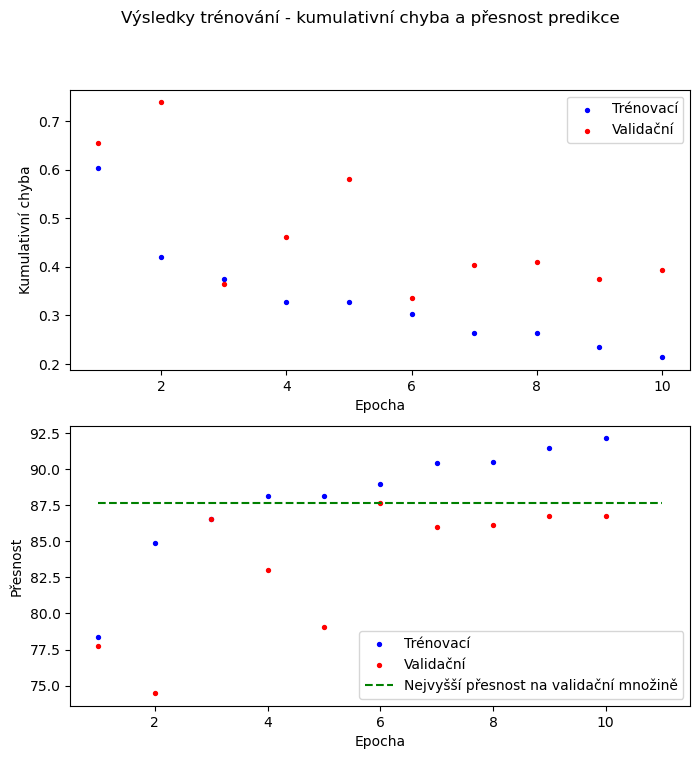

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.2
L2 regularizační člen: 0
Parametr časného zastavení: 5
Velikost dávky: 64

Nejlepší výsledek na validační množině (epocha=10):
  Ztrátová funkce=0.48670, Přesnost=87.87%


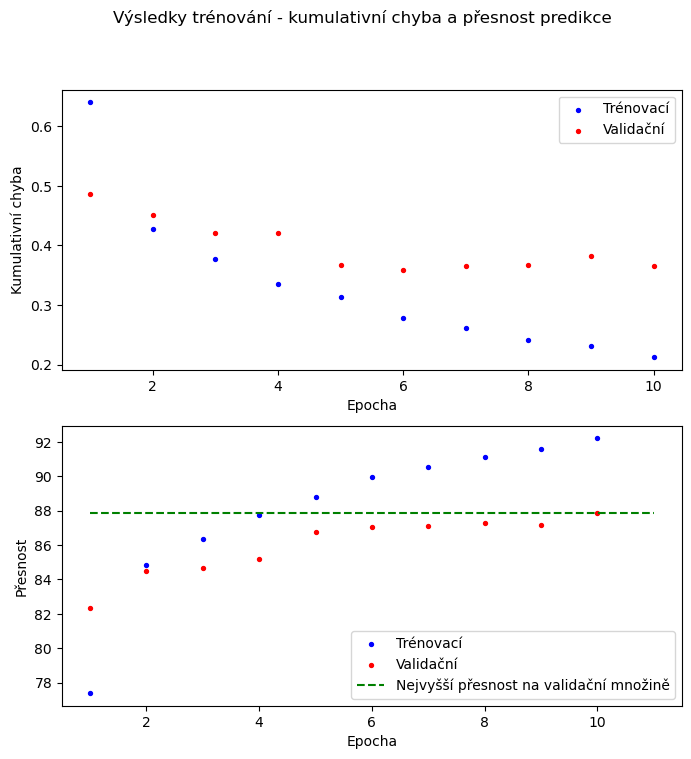

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.0001
Parametr časného zastavení: 5
Velikost dávky: 64

Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.81261, Přesnost=87.98%


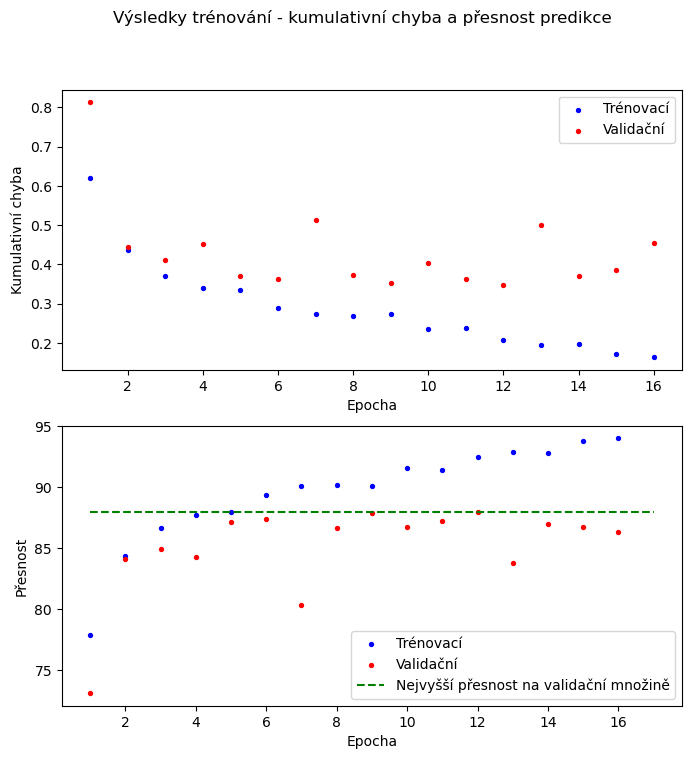

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.2
L2 regularizační člen: 0.0001
Parametr časného zastavení: 5
Velikost dávky: 64

Nejlepší výsledek na validační množině (epocha=10):
  Ztrátová funkce=0.52850, Přesnost=87.95%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 5
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=8):
  Ztrátová funkce=0.49626, Přesnost=88.36%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.2
L2 regularizační člen: 0
Parametr časného zastavení: 5
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=11):
  Ztrátová funkce=0.46359, Přesnost=88.20%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.0001
Parametr časného zastavení: 5
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=7):
  Ztrátová funkce=0.49341, Přesnost=86.88%


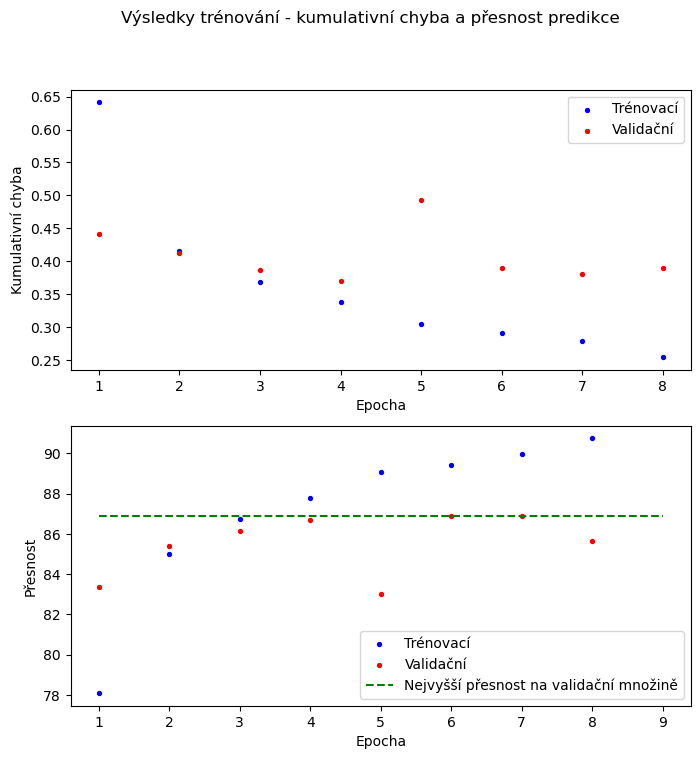

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.2
L2 regularizační člen: 0.0001
Parametr časného zastavení: 5
Velikost dávky: 128

Nejlepší výsledek na validační množině (epocha=9):
  Ztrátová funkce=0.54352, Přesnost=88.57%


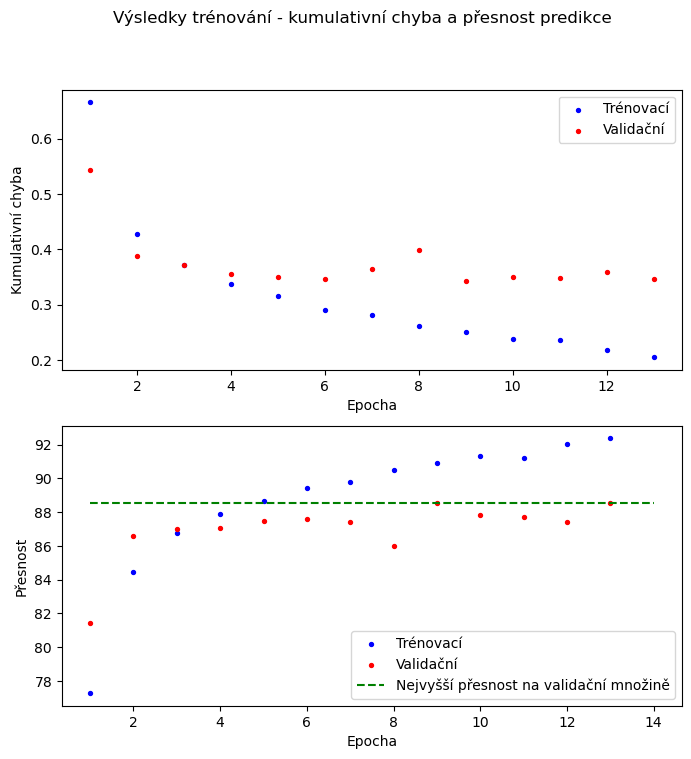

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 5
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=13):
  Ztrátová funkce=0.51812, Přesnost=87.99%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.2
L2 regularizační člen: 0
Parametr časného zastavení: 5
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.52802, Přesnost=88.41%


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.0001
Parametr časného zastavení: 5
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=15):
  Ztrátová funkce=0.47114, Přesnost=88.02%


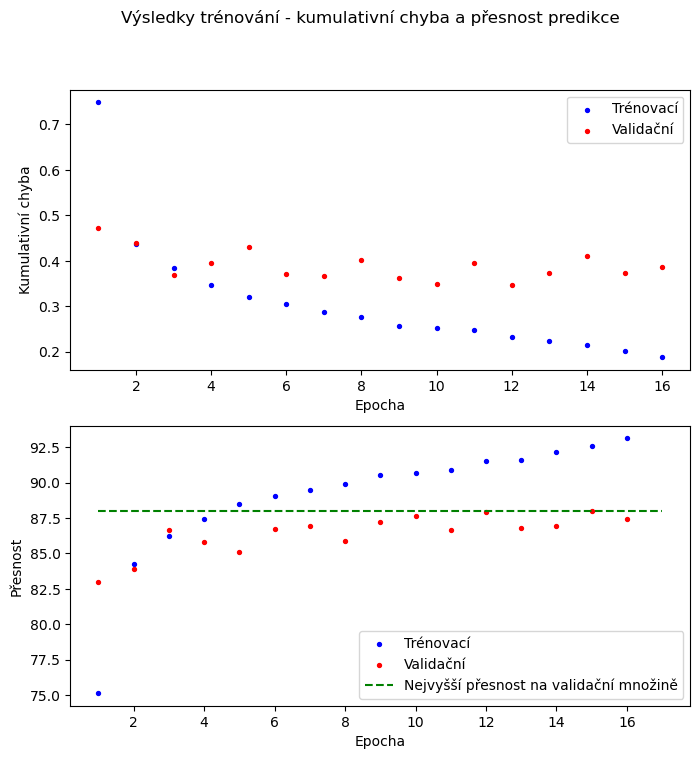

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.2
L2 regularizační člen: 0.0001
Parametr časného zastavení: 5
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=7):
  Ztrátová funkce=0.55663, Přesnost=88.08%


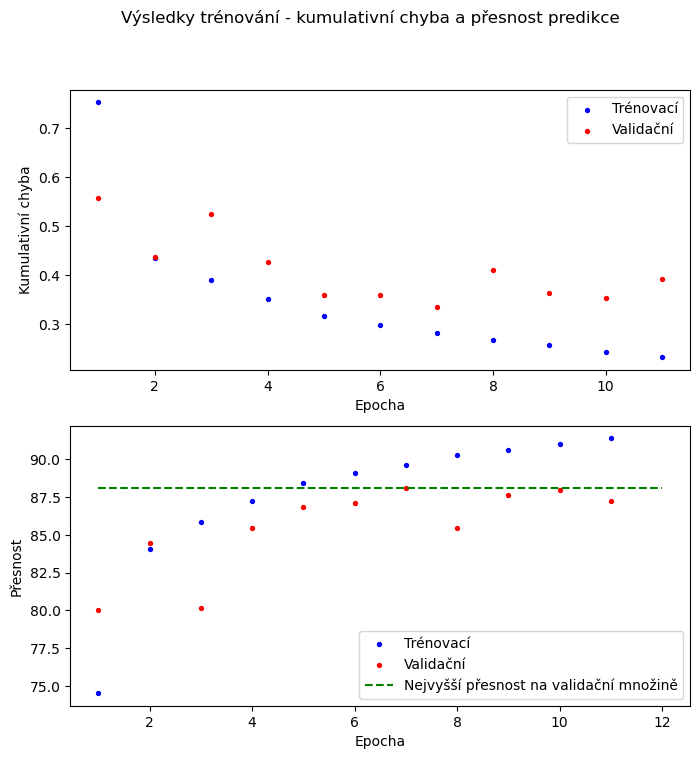

In [42]:
EPOCHS = 100
best_acc = None
for patience in [5]:
    for batch_size in [64, 128, 256]:
        for L2_reg in [0, 0.0001]:
            for dropout_prob in [0, 0.2]:
                for batch_norm in [True]:
                    for hidden in [nn.LeakyReLU()]:
                        for opt_method in [optim.Adam]:
                            # příprava
                            model, optimizer, training_loader, validation_loader = init_model_cnn(hidden, dropout_prob, opt_method, LEARNING_RATE, L2_reg, batch_size, batch_norm)

                            # trénování
                            losses, accs, vlosses, vaccs = train(model, optimizer, LOSS_FN, training_loader, validation_loader, patience, EPOCHS)

                            # získání nejlepšího modelu
                            if not best_acc or np.max(vaccs) > best_acc:
                                final_model = model
                                best_acc = np.max(vaccs)

                            print(f"Optimalizační metoda: {opt_method}")
                            print(f"Aktivační funkce: {hidden}")
                            print(f"Dávková normalizace: {batch_norm}")
                            print(f"Pravděpodobnost vynulování výstupu: {dropout_prob}")
                            print(f"L2 regularizační člen: {L2_reg}")
                            print(f"Parametr časného zastavení: {patience}")
                            print(f"Velikost dávky: {batch_size}")

                            plot_result(losses, accs, vlosses, vaccs)

Jako finální model vyberu konvoluční neuronovou síť s těmito parametry:
* `optimalizační metoda`: **Adam**
* `Dávková normalizace`
* Pravděpodobnost `dropout`: **0.2**
* **bez** `L2 regularizace`
* `Velikost dávky`: **256**
* `Počet epoch`: **11**

## Finální model

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.2
L2 regularizační člen: 0
Parametr časného zastavení: 3
Velikost dávky: 256

Nejlepší výsledek na validační množině (epocha=11):
  Ztrátová funkce=0.51909, Přesnost=88.39%


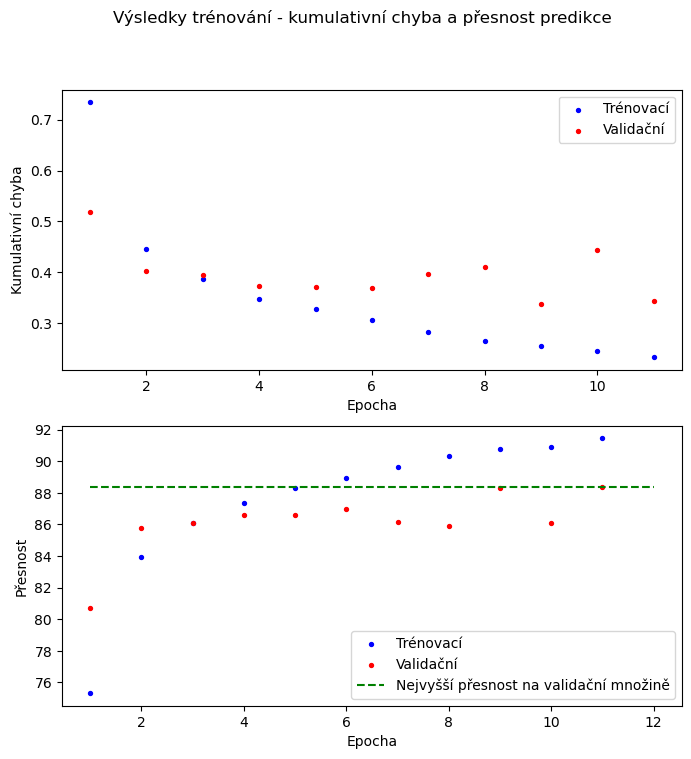

In [30]:
EPOCHS = 12
for patience in [3]:
    for batch_size in [256]:
        for L2_reg in [0]:
            for dropout_prob in [0.2]:
                for batch_norm in [True]:
                    for hidden in [nn.LeakyReLU()]:
                        for opt_method in [optim.Adam]:
                            # příprava
                            final_model, optimizer, training_loader, validation_loader = init_model_cnn(hidden, dropout_prob, opt_method, LEARNING_RATE, L2_reg, batch_size, batch_norm)

                            # trénování
                            losses, accs, vlosses, vaccs = train(final_model, optimizer, LOSS_FN, training_loader, validation_loader, patience, EPOCHS)

                            print(f"Optimalizační metoda: {opt_method}")
                            print(f"Aktivační funkce: {hidden}")
                            print(f"Dávková normalizace: {batch_norm}")
                            print(f"Pravděpodobnost vynulování výstupu: {dropout_prob}")
                            print(f"L2 regularizační člen: {L2_reg}")
                            print(f"Parametr časného zastavení: {patience}")
                            print(f"Velikost dávky: {batch_size}")

                            plot_result(losses, accs, vlosses, vaccs)

#### Odhad přesnosti

Odhadujeme přesnost modelu 88%. Na matici záměn pozorujeme, že model nemá systematickou chybu, ale některé druhy se mu pletou.

In [31]:
with torch.no_grad():
    outputs = final_model(X_Test_tensor)
    predictions = outputs.argmax(1).numpy() # uložení predikcí
    
# Přesnost
print(f"Testovací přesnost: {100 * accuracy_score(y_Test, predictions):.3f}%")

# Matice záměn
print("Matice záměn:")
print(confusion_matrix(y_Test, predictions))

Testovací přesnost: 87.810%
Matice záměn:
[[757   0   9  50   0   0  23   0   2   0]
 [  2 749   0  23   0   0   1   0   0   0]
 [ 19   1 634  19  47   0  73   0   6   0]
 [  8   5   1 851   1   0  13   0   4   0]
 [  3   0  40 102 616   0 103   0   2   0]
 [  1   0   0   2   0 862   0  35   1   4]
 [174   0  41  58  41   0 532   0   2   0]
 [  0   0   0   0   0  19   0 809   2  29]
 [  4   1   2   2   2   2   3   0 791   0]
 [  0   0   0   0   0   4   0  36   2 775]]


In [53]:
# uložení modelu
torch.save(final_model.state_dict(), "final_model.pt")

# Vyhodnocení evaluačních dat

In [32]:
# načtení evaluačních dat
df_eval = pd.read_csv("evaluate.csv")
# transformace na 2D tenzor
data = torch.from_numpy(df_eval.drop("ID", axis=1).values.reshape(-1, 1, 32, 32).astype('float32'))

# příprava výsledného datasetu
result = pd.DataFrame()
result["ID"] = df_eval["ID"]

# predikce
with torch.no_grad():
    final_model.eval() # indikace trénování
    outputs = final_model(data)

predictions = outputs.argmax(1)
result["label"] = predictions.numpy()

Vykreslení 25 náhodných obrázků ukazuje, že model predikuje dobře.

In [55]:
labels = {
    0: "Tričko",
    1: "Kalhoty", 
    2: "Svetr",
    3: "Šaty",
    4: "Kabát",
    5: "Sandály",
    6: "Sukně",
    7: "Tenisky",
    8: "Taška",
    9: "Vysoká bota"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    rand_pos = random.randrange(0, len(data))
    img = data[rand_pos]
    label = predictions[rand_pos]
    figure.add_subplot(rows, cols, i)
    plt.title(labels[int(label)])
    plt.axis("off")
    plt.imshow(img[0,:,:], cmap="gray")
plt.show()

Nakonec výsledek evaluace uložíme do souboru.

In [56]:
# uložení výsledku do souboru
result.to_csv("results.csv")